## 1. Collect Basic Data

### Retrieve CryptoCurrency Market Data ###

In [44]:
import pandas as pd
import yfinance as yf
from functools import reduce
import requests
import time
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


CRYPTO = False

# Crypto Details
cryptoProducts = ["ETH-USD", "USDT-USD", "BTC-USD"]
availableGranularities = dict(zip(["1M", "5M", "15M", "1H", "6H", "1D"], [60, 300, 900, 3600, 21600, 86400]))

# Stock Details
dowTickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA"]  
sse50Tickers = ["600519.SS", "601318.SS", "601857.SS", "600036.SS", "600016.SS", "600000.SS"]  
sensexTickers = ["RELIANCE.BO", "TCS.BO", "INFY.BO", "ICICIBANK.BO", "SBIN.BO", "HINDUNILVR.BO"] 
ftse100Tickers = ["HSBA.L", "BP.L", "GSK.L", "SHEL.L", "BATS.L", "RIO.L"]  
period = "1D"
indexProducts = dowTickers + sse50Tickers + sensexTickers + ftse100Tickers
productIds = indexProducts

if CRYPTO:
    productIds = cryptoProducts
    period = "1H"
    granularity = availableGranularities[period]
    API_THRESHOLD = 300 #Can only get 300 periods at a time from API
    PERIODS_WANTED = 10000

# not a chance
def retrieveCryptoData(productID, granularity, daysBack, endTime):
    API_URL = f"https://api.exchange.coinbase.com/products/{productID}/candles"
    daysBackDaysAgo = timedelta(days=daysBack)
    startTime = datetime.fromisoformat(endTime) - (granularity/86400) * daysBackDaysAgo

    # Convert to isoformat
    startTime = startTime.isoformat()

    # Set Request Parameters
    parameters = {
        "start" : startTime,
        "end" : endTime,
        "granularity" : str(granularity)
    }

    # Actually get data
    data = requests.get(API_URL, params = parameters, headers = {"content-type":"application/json"})
    df = pd.DataFrame(data.json(), columns=["time", "low", "high", "open", "close", "volume"])
    return df


def retrieveIndexData(ticker):
    # Define date range
    startDate = "2009-01-01"
    endDate = "2020-08-05"

    ohlcData = {}
    try:
        stockData = yf.download(ticker, start=startDate, end=endDate)
        ohlcData[ticker] = stockData[["Low", "High", "Open", "Close", "Volume"]]
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

    dfOhlc = pd.concat(ohlcData, axis=1)
    return dfOhlc


dataframes = dict()
RETRIEVE_DATA = False

if RETRIEVE_DATA:
    for productId in productIds:
        if CRYPTO:
            # Fetch PERIODS_WANTED periods of data
            end = (datetime.now()).isoformat()
            for batch in range(PERIODS_WANTED // API_THRESHOLD  + 1):
                amountToFetch = PERIODS_WANTED % API_THRESHOLD if batch == PERIODS_WANTED // API_THRESHOLD else API_THRESHOLD
                tempDF = retrieveCryptoData(productId, granularity, amountToFetch, end)
                timeInSeconds = (tempDF['time'].values)[-1]
                dt = datetime.fromtimestamp(timeInSeconds - granularity)
                end = dt.isoformat() + 'Z'
                value = dataframes.get(productId)
                if productId not in dataframes:
                    dataframes[productId] = tempDF[::-1]
                else:
                    dataframes[productId] = pd.concat([tempDF[::-1], dataframes[productId]])
        else:
            dataframe = retrieveIndexData(ticker=productId)
            columnNames = [value[1].lower() for value in list(dataframe.columns.values)]
            dataframe.columns = columnNames
            dataframes[productId] = dataframe
   
# Required for index data that pull stock data from different exchanges
def commonaliseData(data):
    commonDates = reduce(lambda x, y: x.intersection(y), [df.index for df in data.values()])
    for ticker, df in data.items():
        data[ticker] = df.reindex(commonDates)
        data[ticker]["Times"] = commonDates
    data = {ticker: df.dropna() for ticker, df in data.items()}
    PERIODS_WANTED = data.get(indexProducts[0]).shape[0]
    return data

if not CRYPTO and RETRIEVE_DATA:
    dataframes = commonaliseData(dataframes)

In [45]:
TEST_CORRECT_ORDER = False

if TEST_CORRECT_ORDER:
    testTime = dataframes[productIds[0]]['time'].values
    testTime -= testTime[0]
    plt.figure(figsize=(10, 6))
    plt.plot(testTime, color="blue")
    plt.title(f"Test Correct Order")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

## 2. Augment State Space (add indicators)

### Indicator 1: Exponential Moving Average ###

In [46]:
import matplotlib.pyplot as plt

def EMA(array, N):
    """
    EMA_t = (Price_t * α) + (EMA_(t-1) * (1 - α))
    where:
    EMA_t = Exponential Moving Average at time t
    Price_t = Price at time t
    α (alpha) = Smoothing factor, calculated as 2 / (N + 1)
    N = Number of periods
    """
    smoothingParameter = 2/(N + 1)
    finalArray = [array[0]]
    for i in range(1, len(array)):
        finalArray.append(array[i] * smoothingParameter + finalArray[i-1] * (1 - smoothingParameter))
    return np.array(finalArray)

# expMA = EMA(closingPrices, t)
# plt.figure(figsize=(10, 6))
# plt.plot(expMA, label=f"Exponential Moving Average: T={t}", color="red")
# plt.plot(closingPrices, label="Actual Closing Prices", color="blue")
# plt.title(f"Price Data")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

### Indicator 2: Momemtum

In [47]:
def Momentum(array):
    # Percentage Change in Price/Time
    momentumArray = [(array[i] - array[i-1]) /array[i-1] for i in range(1, len(array))]
    momentumArray.insert(0, np.nan)
    return np.array(momentumArray)

# momentum = Momentum(closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(momentum*100, color="green")
# plt.title(f"Momentum Data (as %)")
# plt.xlabel("Time")
# plt.ylabel("Momentum")
# plt.legend()
# plt.show()

### Indicator 3: Average True Range

In [48]:

def trueRange(high, low, close):
    # TR = Max[(H - L), |H - C|, |L - C|
    closing = np.insert(close, 0, np.nan, axis=0)[:len(close)]
    return np.maximum(high - low, np.abs(high - closing), np.abs(low - closing))

def averageTrueRange(high, low, close, n=14):
    trueRanges = trueRange(high, low, close)
    atr = np.empty_like(trueRanges)
    atr[:n] = np.nan  # First n values are NaN
    atr[n-1] = np.mean(trueRanges[:n])  # Initial ATR value (simple average of the first n TRs)
    for i in range(n+1, len(trueRanges)):
        atr[i] = (atr[i-1] * (n - 1) + trueRanges[i]) / n
    return atr

# aTRIndicator = averageTrueRange(highs, lows, closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(aTRIndicator, color="Brown")
# plt.title(f"Average True Range over Time")
# plt.xlabel("Time")
# plt.ylabel("Average True Range")
# plt.legend()
# plt.show()

### Indicator 4: Commodity Channel Index

In [49]:
def commodityChannelIndex(high, low, close, n=20):
    # (Typical Price - 20_Day Moving Average) / .015 x Mean Deviation
    typicalPrices = (high + low + close) / 3
    
    movingAverage = np.full_like(high, np.nan)
    meanDeviation = np.full_like(high, np.nan)
    
    for i in range(n, len(typicalPrices)):
        movingAverage[i] = np.mean(typicalPrices[i-n:i])
        meanDeviation[i] = np.mean(np.abs(typicalPrices[i-n:i] - movingAverage[i]))
    
    cci = np.full_like(high, np.nan, dtype=np.float64)

    numerator = typicalPrices[n:] - movingAverage[n:]
    denominator = 0.015 * meanDeviation[n:]
    result = np.empty_like(numerator)

    np.divide(numerator, denominator, out=result, where=(denominator != 0))
    # a little hacky...
    result[denominator == 0] = 0

    cci[n:] = result
    return cci

# # CCI = commodityChannelIndex(highs, lows, closingPrices)
# # plt.figure(figsize=(10, 6))
# # plt.plot(CCI, color="black")
# # plt.title(f"Commodity Channel Index over Time")
# # plt.xlabel("Time")
# # plt.ylabel("Commodity Channel Index")
# # plt.legend()
# # plt.show()

### Indicator 5: MACD

In [50]:
"""
MACD = 12-day EMA - 26-day EMA
Signal Line = 9-day EMA of MACD
MACD Histogram = MACD - Signal Line
where EMA stands for Exponential Moving Average
"""

def MACD(array):
    return EMA(array, 12) - EMA(array, 26)

def MACDSignal(array):
    return EMA(MACD(array), 9)

MACDHistogram = lambda x : MACD(x) - MACDSignal(x)

# mACD = MACD(closingPrices)
# signalLine = MACDSignal(closingPrices)
# macdHistogram = MACDHistogram(mACD, signalLine)

# plt.figure(figsize=(10, 6))
# plt.plot(mACD, color="blue", label = "MACD Line")
# plt.plot(signalLine, color = "red", label = "Signal Line")
# plt.plot(macdHistogram, color = "black", label = "Histogram")
# plt.title(f"Moving Average Convergence-Divergence")
# plt.xlabel("Time")
# plt.ylabel("MACD")
# plt.legend()
# plt.show()

## 3. Collate All Features Into DataFrame

In [51]:
import os

CCI_T, ATR_T = 20, 14
if RETRIEVE_DATA:
    for product in productIds:
        df = dataframes[product]
        close = df["close"].values
        volume = df["volume"].values
        highs = df["high"].values
        lows = df["low"].values
        df['E_M_A'] = EMA(close, N=30)
        df['Momentum'] = Momentum(close)
        df['Av_True_Range'] = averageTrueRange(highs, lows, close, 14)
        df['CCI'] = commodityChannelIndex(highs, lows, close, 20)
        df['MACDHist'] = MACDHistogram(close)
        df["Return"] = df["close"].pct_change().fillna(0)
        # Reset Indexes
        df = df.reset_index(drop=True)
        dataframes[product] = df
        if not os.path.exists("CSVs/"):
            os.makedirs("CSVs/")
        df.to_csv(f"CSVs/{product}_{period}_periods.csv", sep='\t')
else:
    for productId in productIds:
        df = pd.read_csv(f"CSVs/{productId}_{period}_periods.csv", sep='\t')
        dataframes[productId] = df.iloc[:, 1:]  # Drops the first column

times = None
for product in productIds:
    df = dataframes[product]
    times = df['Times']
    dataframes[product] = df.drop('Times', axis=1)

## 4. Environment and Training Process

### Comparison Strategies

In [52]:
sse50BuyAndHold =  np.array([0] + [1/len(sse50Tickers) if i in sse50Tickers else 0 for i in productIds])
sensexBuyAndHold = np.array([0] + [1/len(sensexTickers) if i in sensexTickers else 0 for i in productIds])
ftse100BuyAndHold = np.array([0] + [1/len(ftse100Tickers) if i in ftse100Tickers else 0 for i in productIds])
dowBuyAndHold = np.array([0] + [1/len(dowTickers) if i in dowTickers else 0 for i in productIds])
buyAndHoldAll = np.array([0] + [1/(len(productIds)) for i in productIds])

#Non
NON_RL_COMPARISON_STRATEGIES = {
    "SSEBuyAndHold" : sse50BuyAndHold,
    "SENSEXBuyAndHold" : sensexBuyAndHold,
    "FTSEBuyAndHold" : ftse100BuyAndHold,
    "DOWBuyAndHold" : dowBuyAndHold,
    "BuyAndHoldAll" : buyAndHoldAll
}

### Hyperparameters (most of them)

In [53]:
from collections import defaultdict


NUMBER_OF_ASSETS = len(productIds)
NUMBER_OF_FEATURES = len((list(dataframes.values())[0]).columns) # CHECK THIS ISN'T A PROBLEM 
if not CRYPTO:
    PERIODS_WANTED = list(dataframes.values())[0].shape[0]
EXPERIMENTS = 2
TRAINING_PERIODS = int(PERIODS_WANTED / EXPERIMENTS) # will probably have to change this to times
TIME_WINDOW = 30
LEARNING_FREQUENCIES = (TRAINING_PERIODS / np.array([10, 20, 30, 40])).astype(int)
START_CASH = 1000000
LSTMHIDDENSIZE = 512
AGENT_RISK_AVERSIONS = np.array([1, 2, 3, 4]) / 2 #i know, this probably shouldn't go here
START_INDEX = max(ATR_T, CCI_T) #Sufficient data is not available for the first START_INDEX periods
STRATEGIES = ["SSEBuyAndHold", "SENSEXBuyAndHold", "FTSEBuyAndHold", "DOWBuyAndHold", "BuyAndHoldAll", "PPOLSTM", "RANDOM"]
REPEATS = 5
LSTMOUTPUTSIZES = [64, 128, 256, 512]
STARTS = [0] + [i *  TRAINING_PERIODS + -TIME_WINDOW for i in range(1, EXPERIMENTS)]
PORTFOLIO_TRAJECTORIES = []
REWARD_FUNCTIONS = ["CVaR", "Standard Logarithmic Returns", "Differential Sharpe Ratio"]
NUMBER_OF_PARALLEL_ENVIRONMENTS = 4
averagePerformance = defaultdict(lambda: [])
allResults = defaultdict(lambda: [])

In [54]:
# Thing being tested
TESTING = {
    "RISK_AVERSION" : False,
    "LSTM_OUTPUT_SIZE" : True,
    "REWARD_FUNCTION" : False,
    "LEARNING_FREQUENCY": False
}

#### Some helper functions for metrics

In [55]:
from utils import tabulate_neatly

def printConfiguration(agent=None, freq=None):
    table = [["LSTM Hidden Size", "LSTM Output Size", "Learning Frequency", "Agent Risk Aversion"]]
    table.append([LSTMHIDDENSIZE, agent.state_n, freq, agent.riskAversion])
    tabulate_neatly(table, headers="firstrow", title=f"Configuration:")

def plotAllocations(allocations, title=None):
    categories = ['Cash'] + productIds
    plt.figure(figsize=(20,5))
    plt.bar(categories, allocations)
    plt.xlabel('Allocations')
    plt.tick_params(axis='x', labelsize=6)
    plt.ylabel('Proportion Allocated')
    plt.title('Allocations' if title == None else title)
    plt.show()

def generateConfigLabel(strategy, agent, episode, rewardFunction, freq):
    firstTag = f"Strategy: {strategy}" 
    lastTag = f"Experiment {episode + 1}"
    innerTag = None
    boole = (strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM")
    if TESTING["RISK_AVERSION"]:
        innerTag = (f"Risk Aversion: {agent.riskAversion}" if boole else "")
    elif TESTING["LSTM_OUTPUT_SIZE"]:
        innerTag = (f"LSTM Output Size: {agent.state_n}" if boole else "")
    elif TESTING["REWARD_FUNCTION"]:  
        innerTag = (f"Reward Function: {rewardFunction}" if boole else "")
    elif TESTING["LEARNING_FREQUENCY"]:  
        innerTag = (f"Update Frequency: {freq}" if boole else "")
    
    if (TESTING["RISK_AVERSION"] or TESTING["LSTM_OUTPUT_SIZE"] or TESTING["REWARD_FUNCTION"] or TESTING["LEARNING_FREQUENCY"]) and boole:
        firstTag, innerTag = innerTag, firstTag
    return firstTag + " | " +  innerTag + " | " + lastTag


### Actual Training

In [57]:
import torch
from PPO import PPOAgent
from TD3 import td3Agent
from LstmFeatureExtractor import LstmFeatureExtractor
from TimeSeriesEnvironment import TimeSeriesEnvironment
from scipy.special import softmax

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Default Arguments Will need to be changed...
def trainingLoop(riskAversion=0, lstmOutputSize=192, rewardFunction="CVaR", freq=int(TRAINING_PERIODS/25)):
    for repeat in range(REPEATS):
        for strategy in STRATEGIES:
            if repeat > 0 and strategy != "PPOLSTM":
                continue
            for episode in range(EXPERIMENTS):
                start = episode *  TRAINING_PERIODS + (START_INDEX if episode == 0 else -TIME_WINDOW)
                featureExtractor = LstmFeatureExtractor(None, NUMBER_OF_ASSETS, TIME_WINDOW, NUMBER_OF_FEATURES, freq, LSTMHIDDENSIZE, lstmOutputSize)
                agent = PPOAgent( 
                        state_n=lstmOutputSize, 
                        actions_n=len(productIds),
                        alpha=3e-4,
                        policyClip = 0.2,
                        gamma=0.99,
                        lstmHiddenSize=LSTMHIDDENSIZE,
                        actor_noise=0,
                        batch_size=128,
                        fc1_n=512,
                        fc2_n=384,
                        gaeLambda=0.98,
                        epochs=10,
                        riskAversion=riskAversion,
                    )
                # Insufficient time...
                # if strategy == "TD3":
                #     agent = agentTd3
                #     agent.riskAversion = riskAversion
                #     agent.state_n = lstmOutputSize
                env = TimeSeriesEnvironment(dataframes, start, TIME_WINDOW, TRAINING_PERIODS, lstmOutputSize, featureExtractor, START_CASH, riskAversion, 2.5e-4)
                env.reset()
                done = False
                doNothing = False
                while not done:
                    if strategy not in NON_RL_COMPARISON_STRATEGIES.keys():
                        if not env.getIsReady():
                            for warmUp in range(TIME_WINDOW):
                                """
                                'warm up' environment until there's enough data to calculate CVaR
                                """
                                allocations = np.random.normal(scale=1, size=len(productIds))
                                allocations = np.insert(allocations, 0, 1)
                                _, __, done, ___, ____ = env.step(softmax(allocations), False, rewardMethod = rewardFunction)
                            env.setIsReady(True)
                    #If there's enough data left for the LSTM to process
                    if (not (env.getData(useExtractor=False)).size % (featureExtractor.numAssets * featureExtractor.timeWindow * featureExtractor.numFeatures)):
                        observation = None
                        
                        if strategy == "PPOLSTM" or strategy == "TD3":
                            data = env.getData(useExtractor=False)
                            observation = featureExtractor.forward(torch.tensor(data, dtype=torch.float32))
                            if strategy == "PPOLSTM":
                                action, probabilities, valuation = agent.select_action(observation)
                                action = action.numpy()
                            # elif strategy == "TD3":
                            #     action = agent.select_action(observation=observation)
                            fear = None
                            if agent.riskAversion != 0:
                                fear = 2 * (min(env.getCurrentTurbulence()/env.turbulenceThreshold, 1))**(1/(2*agent.riskAversion)) - 1
                            else:
                                fear = 2 * (min(env.getCurrentTurbulence()/env.turbulenceThreshold, 1)) - 1
                            action = np.insert(action, 0, fear)
                            if doNothing:
                                allCashAction = np.array([1] + [0 for i in productIds])
                            else:
                                env.traded += 1
                        elif strategy == "RANDOM":
                            action = np.random.normal(0, 1, len(productIds) + 1)
                            env.traded += 1
                        else:
                            action = NON_RL_COMPARISON_STRATEGIES[strategy]
                            env.traded += 1
                        
                        if not doNothing:
                            finalAction = [0] + action if strategy in NON_RL_COMPARISON_STRATEGIES.keys() else softmax(action)
                        else:
                            finalAction = allCashAction

                        next, reward, done, __, info = env.step(finalAction, haveEffect = (env.timeStep)/TRAINING_PERIODS >= 2/3, rewardMethod=rewardFunction) # make this more efficient

                        if strategy == "PPOLSTM" or strategy == "TD3":
                            doNothing = info["turbulence_breached"]
                            if strategy == "PPOLSTM":
                                agent.store(
                                    data,
                                    finalAction[1:],
                                    probabilities,
                                    valuation,
                                    float(reward),
                                    done,
                                )
                            # else:
                            #     agent.store(
                            #         torch.from_numpy(data),
                            #         torch.from_numpy(action[1:]),
                            #         float(reward),
                            #         torch.from_numpy(featureExtractor.forward(next)), 
                            #         done,
                            #     )
                            # agent begins learning after collecting min required experience
                            if (env.timeStep % freq) == 0:
                                agent.train(featureExtractor)
                    else:
                        done = True
                        print("Traded: ", env.traded)
                    if done:
                        dataString  = generateConfigLabel(strategy, agent, episode, rewardFunction, freq)
                        metrics = env.getMetrics()
                        if strategy in NON_RL_COMPARISON_STRATEGIES.keys():
                            metrics["Average Profitability \nper Trade"] = "N/A"
                        table = [metrics.keys()]
                        table.append(metrics.values())
                        tabulate_neatly(table, headers="firstrow", title=f"{dataString}")
                        if strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM":
                            printConfiguration(agent, freq)
                            plotAllocations([0] + action if strategy in NON_RL_COMPARISON_STRATEGIES.keys() else softmax(action), "Final Allocations")
                        averagePerformance[dataString].append(env.PORTFOLIO_VALUES)
                        allResults[dataString].append(metrics)



TESTING LSTMOUTPUTSIZE


Strategy: SSEBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
72.74,115,32.2281,N/A,0.0543,1111


Strategy: SSEBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
25.39,32.74,41.5565,N/A,0.0448,1111


Strategy: SENSEXBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
54.45,67.07,43.2318,N/A,0.0942,1111


Strategy: SENSEXBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.95,33.15,52.6666,N/A,0.0399,1111


Strategy: FTSEBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-10.91,6.27,36.0202,N/A,-0.0272,1111


Strategy: FTSEBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-21.69,11.37,48.5496,N/A,-0.0377,1111


Strategy: DOWBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
46.76,48,65.8075,N/A,0.0766,1111


Strategy: DOWBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
160.68,160.68,71.3505,N/A,0.1207,1111


Strategy: BuyAndHoldAll | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
40.34,48.28,38.3558,N/A,0.0912,1111


Strategy: BuyAndHoldAll | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
39.21,40.88,48.137,N/A,0.0712,1111


LSTM Output Size: 64 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31.88,37.72,25.1848,929.445,0.0859,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,64,44,0


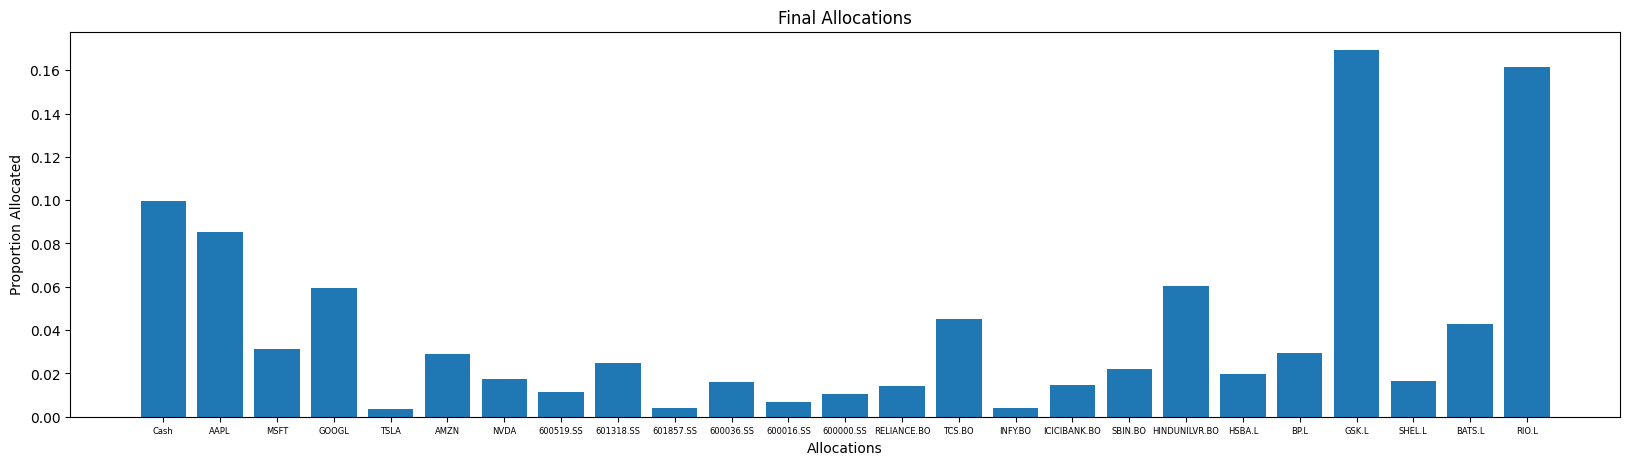

LSTM Output Size: 64 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
41.02,50.24,33.9849,1111.57,0.0661,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,64,44,0


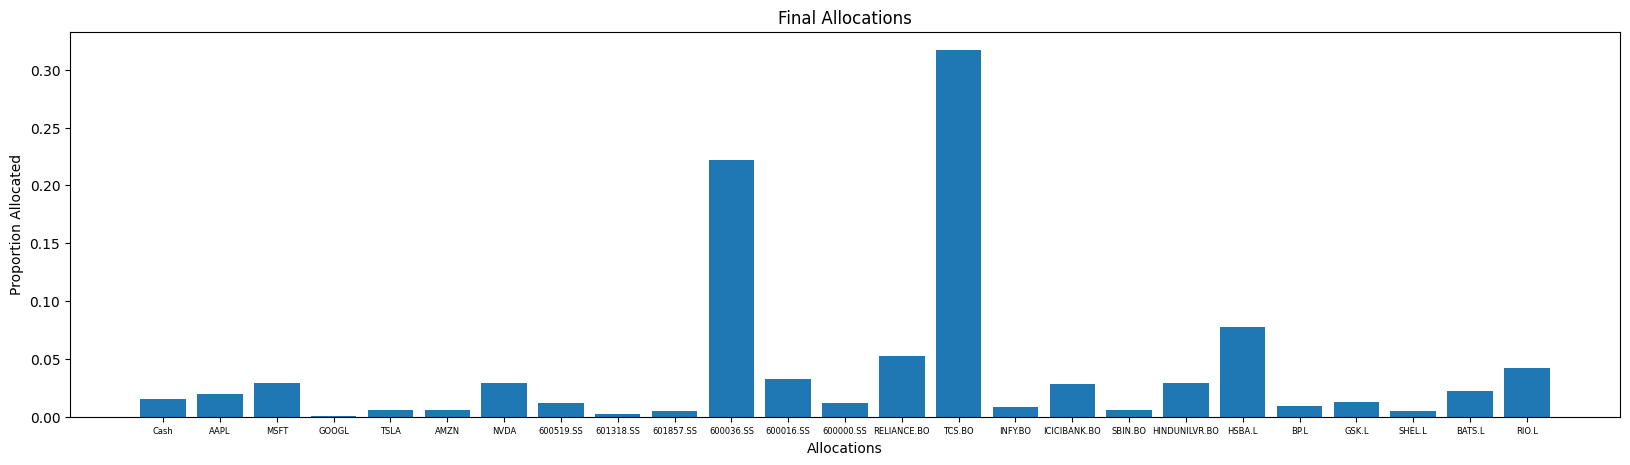

Strategy: RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.48,49.01,31.2023,988.727,0.0771,1111


Strategy: RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.03,23.92,41.7307,624.043,0.044,1111


LSTM Output Size: 64 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31.66,42.36,17.9988,923.018,0.0751,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,64,44,0


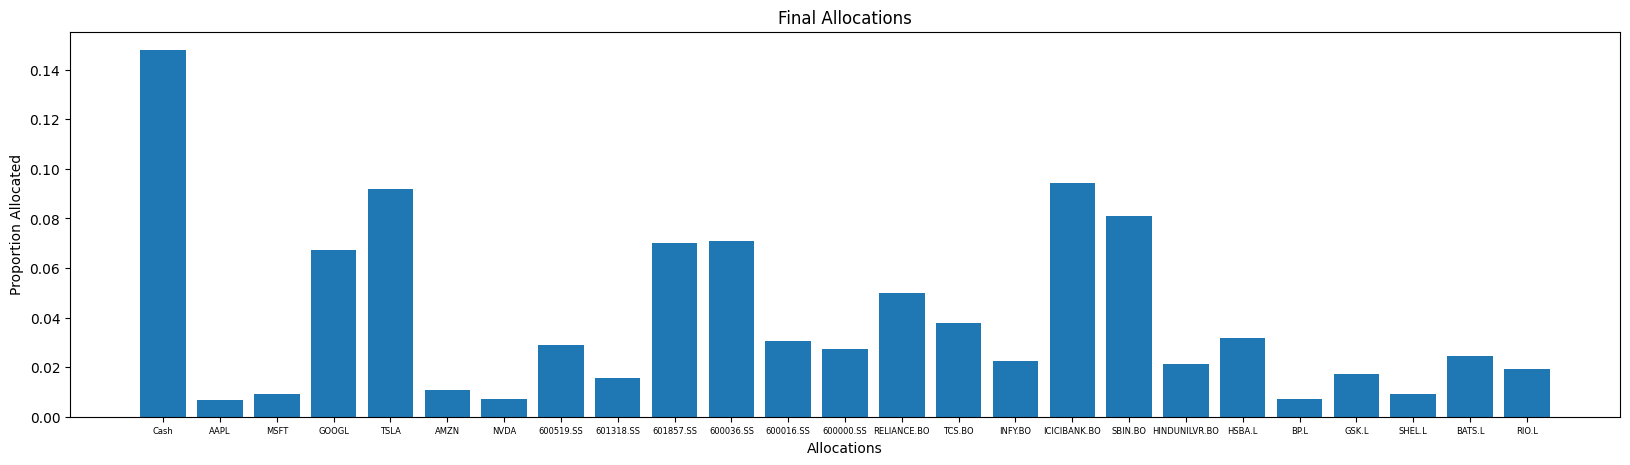

LSTM Output Size: 64 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
29.2,33.77,51.0981,791.452,0.0584,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,64,44,0


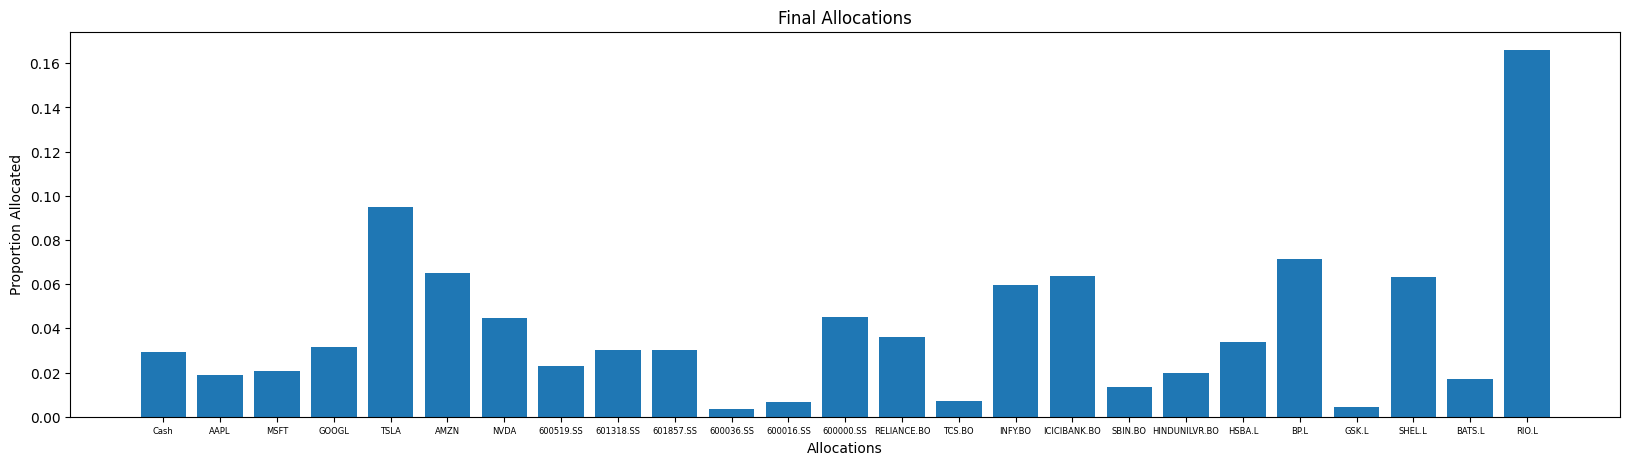

LSTM Output Size: 64 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
7.31,17.55,19.0718,212.981,0.0227,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,64,44,0


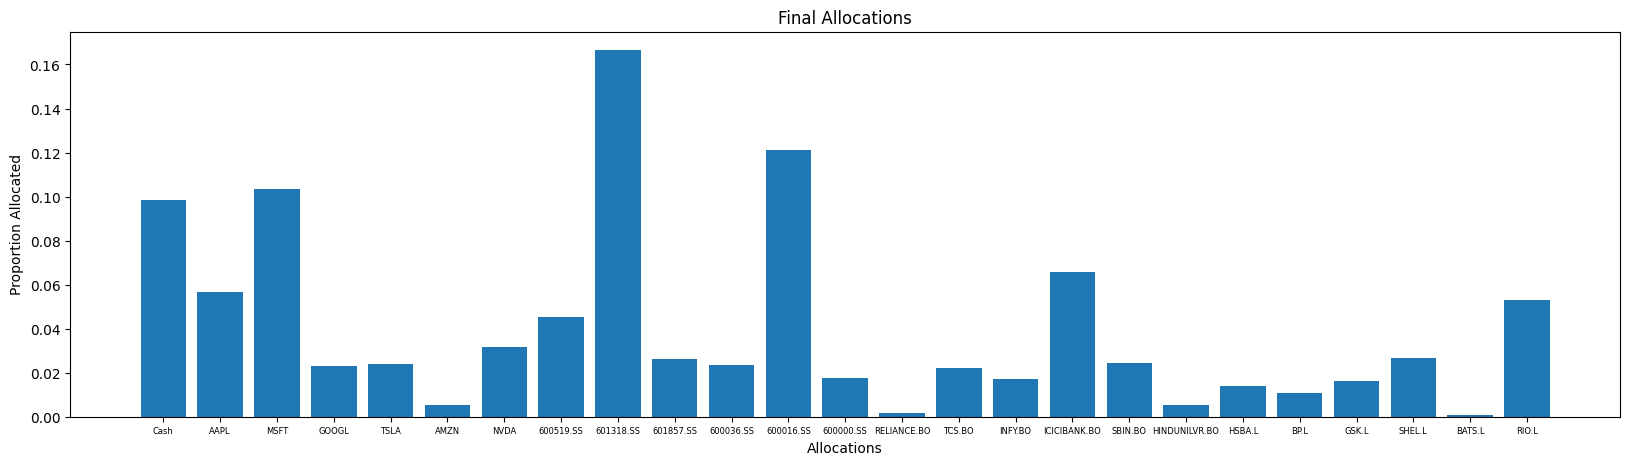

LSTM Output Size: 64 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.82,26.46,45.819,672.725,0.0478,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,64,44,0


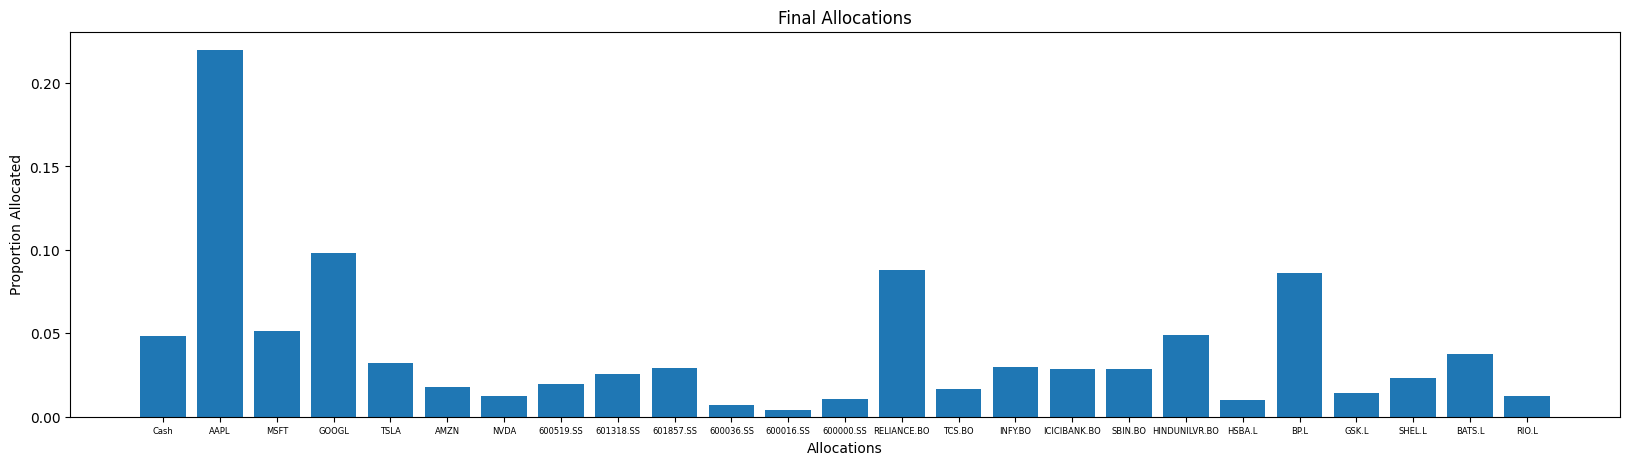

LSTM Output Size: 64 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.03,33.93,29.1243,758.793,0.0691,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,64,44,0


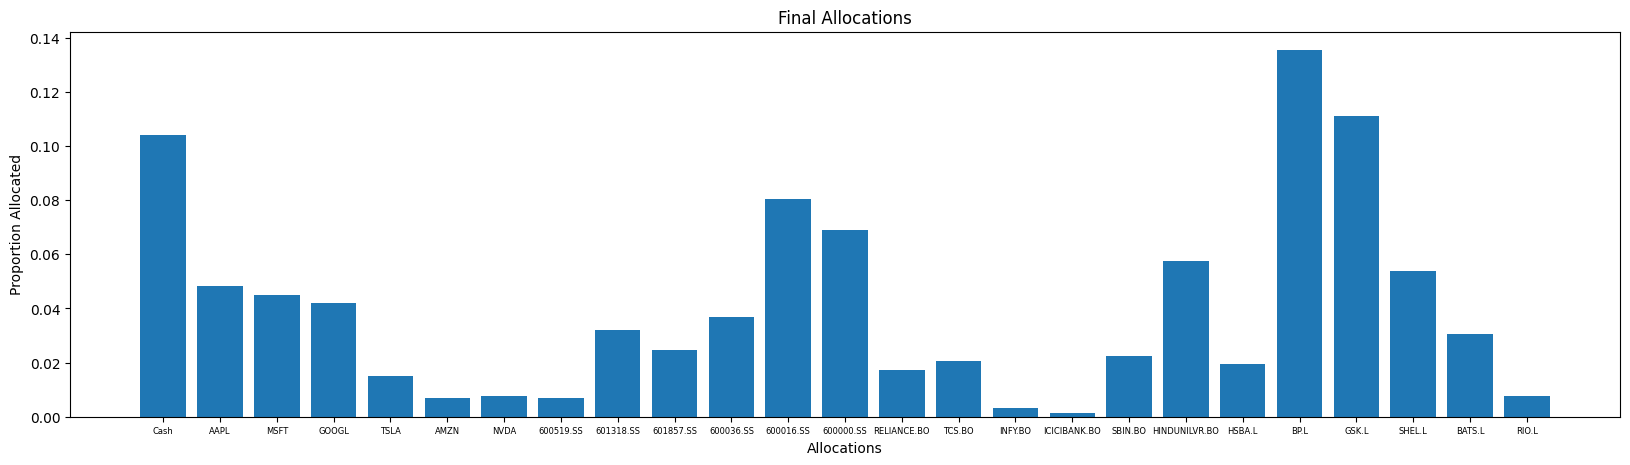

LSTM Output Size: 64 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
15.1,20.13,41.3365,409.254,0.0294,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,64,44,0


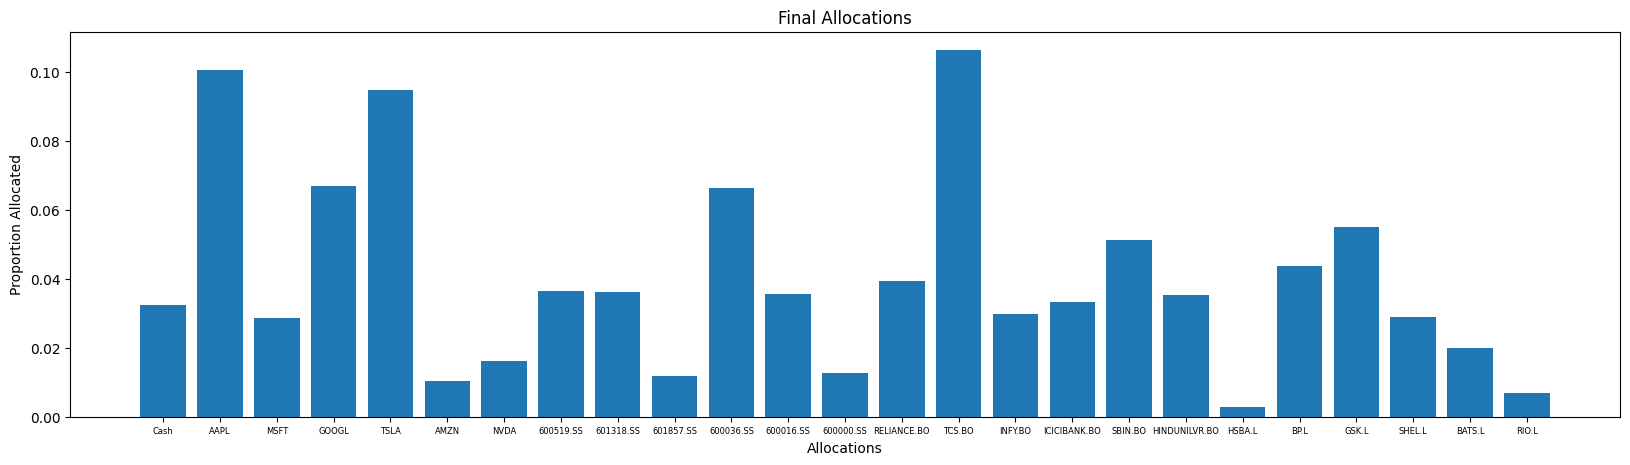

LSTM Output Size: 64 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.4,31.18,32.1841,565.652,0.0579,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,64,44,0


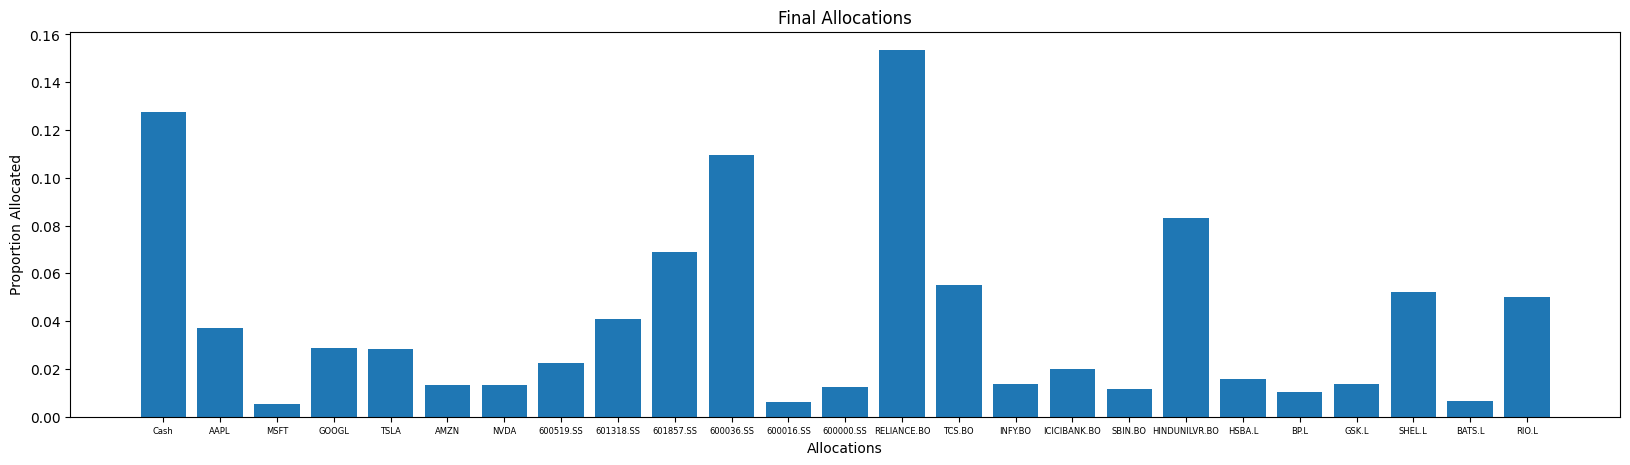

LSTM Output Size: 64 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.02,25.66,41.3467,623.916,0.0434,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,64,44,0


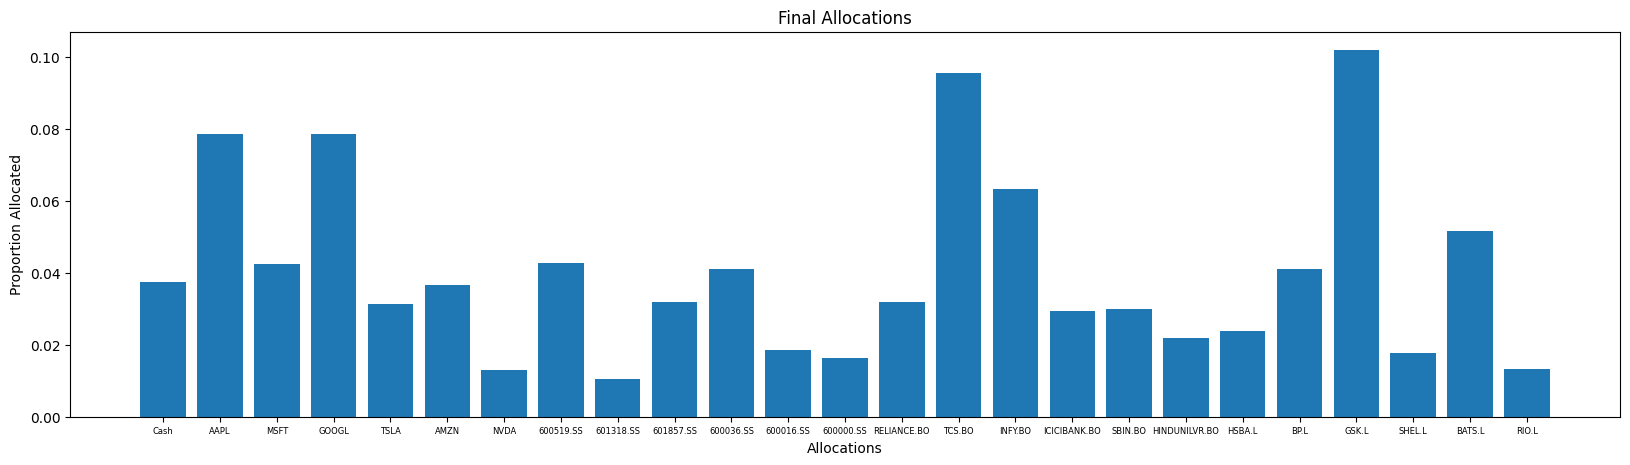

Strategy: SSEBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
72.74,115,32.2281,N/A,0.0543,1111


Strategy: SSEBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
25.39,32.74,41.5565,N/A,0.0448,1111


Strategy: SENSEXBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
54.45,67.07,43.2318,N/A,0.0942,1111


Strategy: SENSEXBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.95,33.15,52.6666,N/A,0.0399,1111


Strategy: FTSEBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-10.91,6.27,36.0202,N/A,-0.0272,1111


Strategy: FTSEBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-21.69,11.37,48.5496,N/A,-0.0377,1111


Strategy: DOWBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
46.76,48,65.8075,N/A,0.0766,1111


Strategy: DOWBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
160.68,160.68,71.3505,N/A,0.1207,1111


Strategy: BuyAndHoldAll | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
40.34,48.28,38.3558,N/A,0.0912,1111


Strategy: BuyAndHoldAll | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
39.21,40.88,48.137,N/A,0.0712,1111


LSTM Output Size: 128 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21,29.39,19.5327,612.173,0.0592,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,128,44,0


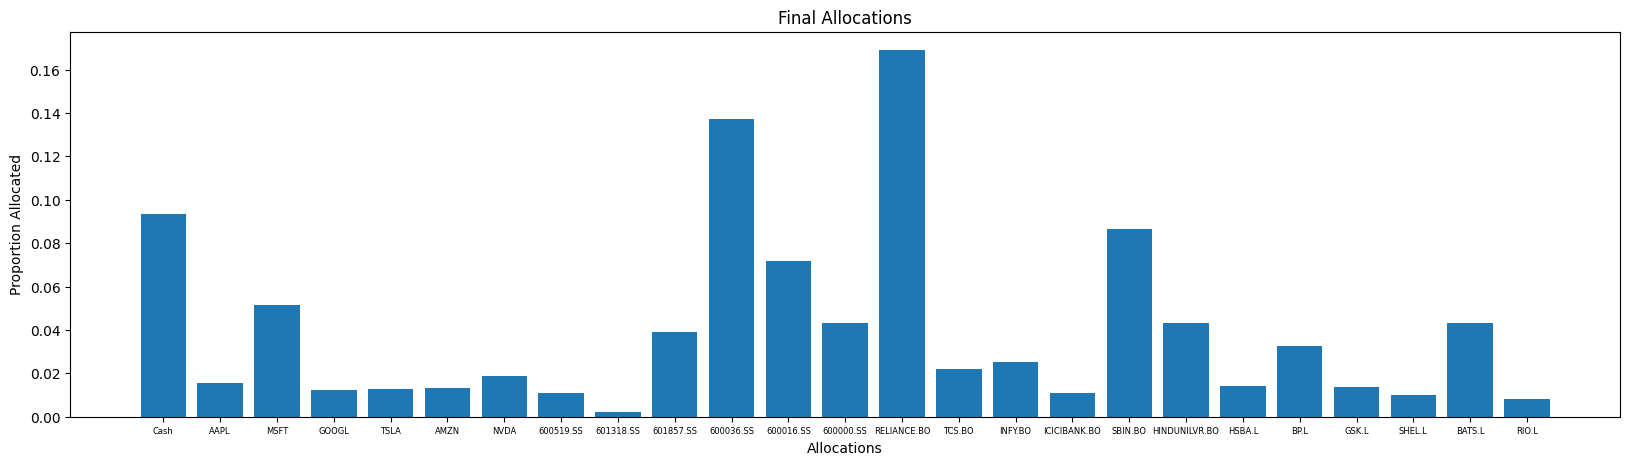

LSTM Output Size: 128 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
25.48,28.07,42.942,690.571,0.0492,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,128,44,0


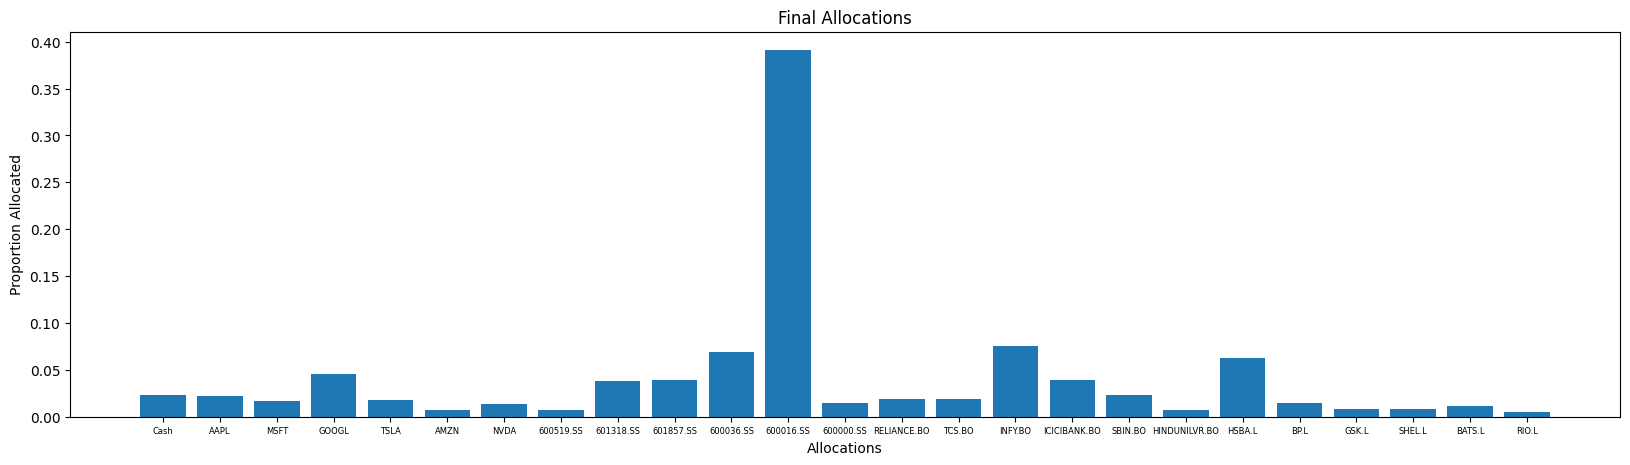

Strategy: RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.32,31.24,24.4159,496.422,0.042,1111


Strategy: RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.33,25.67,44.3645,632.194,0.0475,1111


LSTM Output Size: 128 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.85,38.86,24.5835,986.769,0.086,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,128,44,0


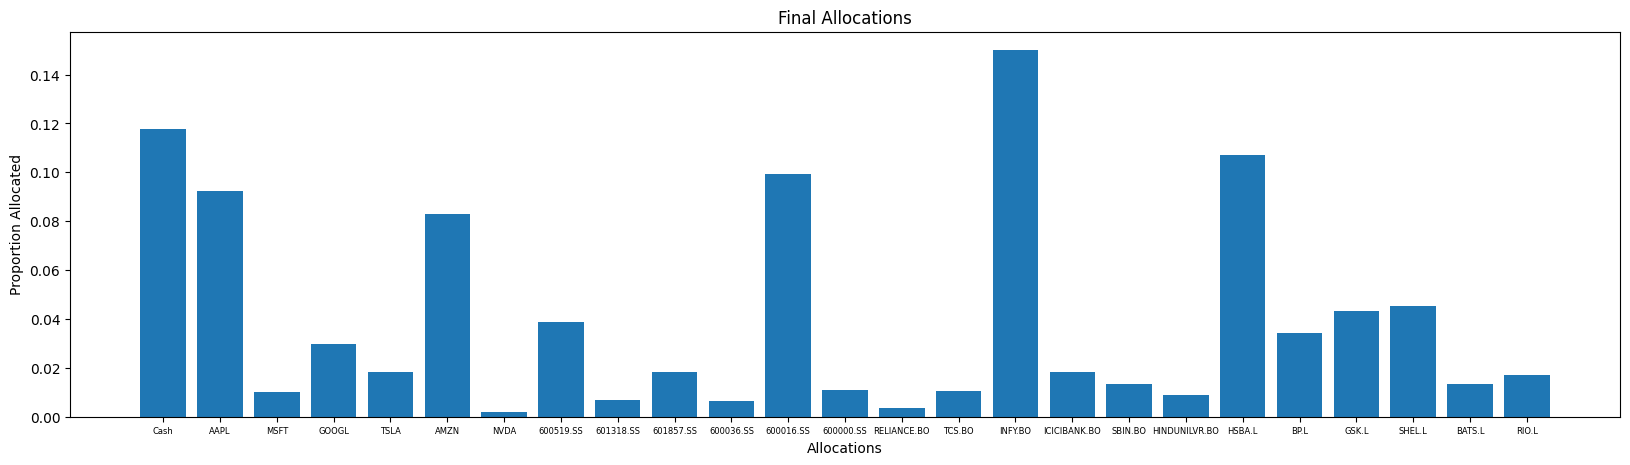

LSTM Output Size: 128 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
6.82,19.98,32.4189,184.914,0.0141,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,128,44,0


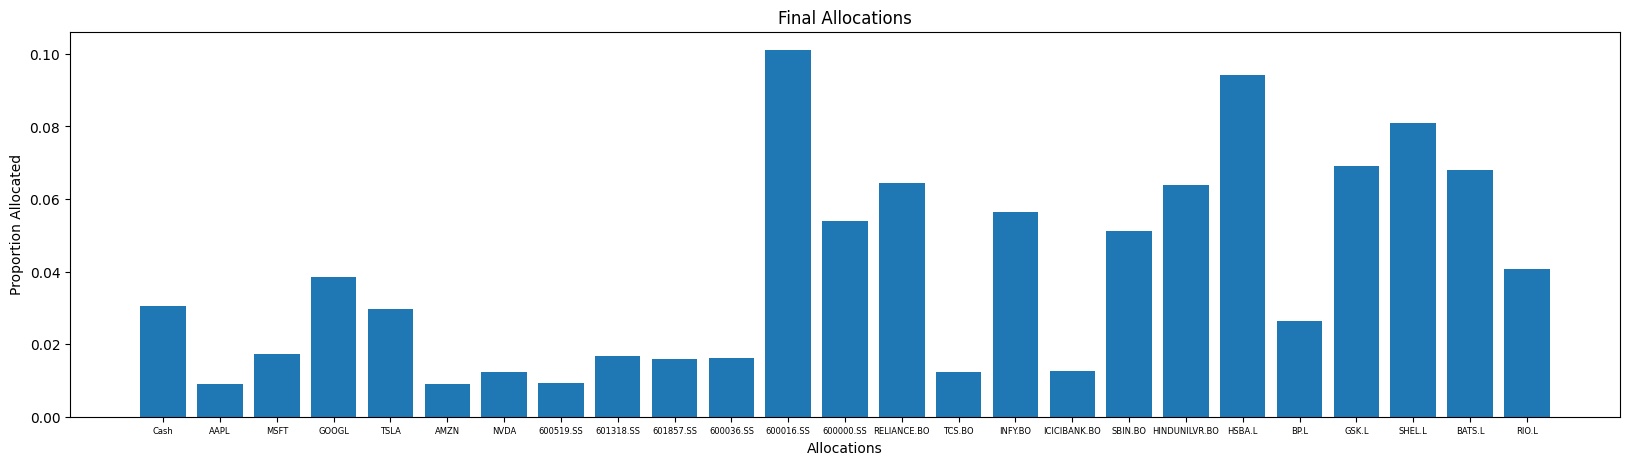

LSTM Output Size: 128 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
28.46,38.46,30.998,829.802,0.076,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,128,44,0


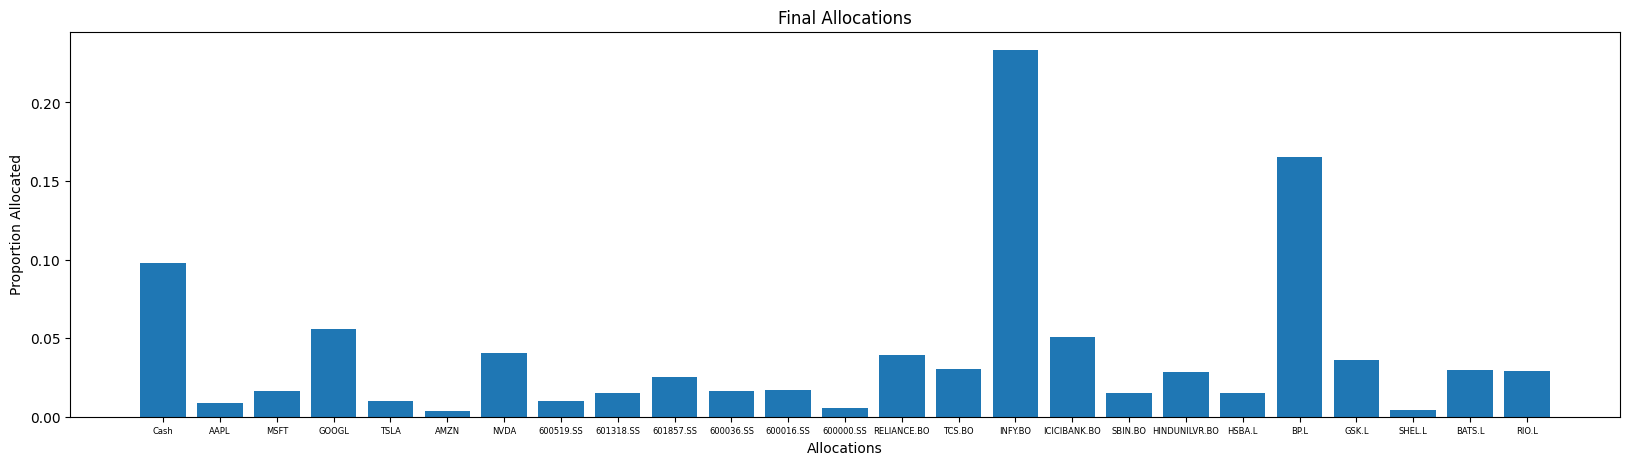

LSTM Output Size: 128 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.73,31.21,28.089,751.427,0.0524,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,128,44,0


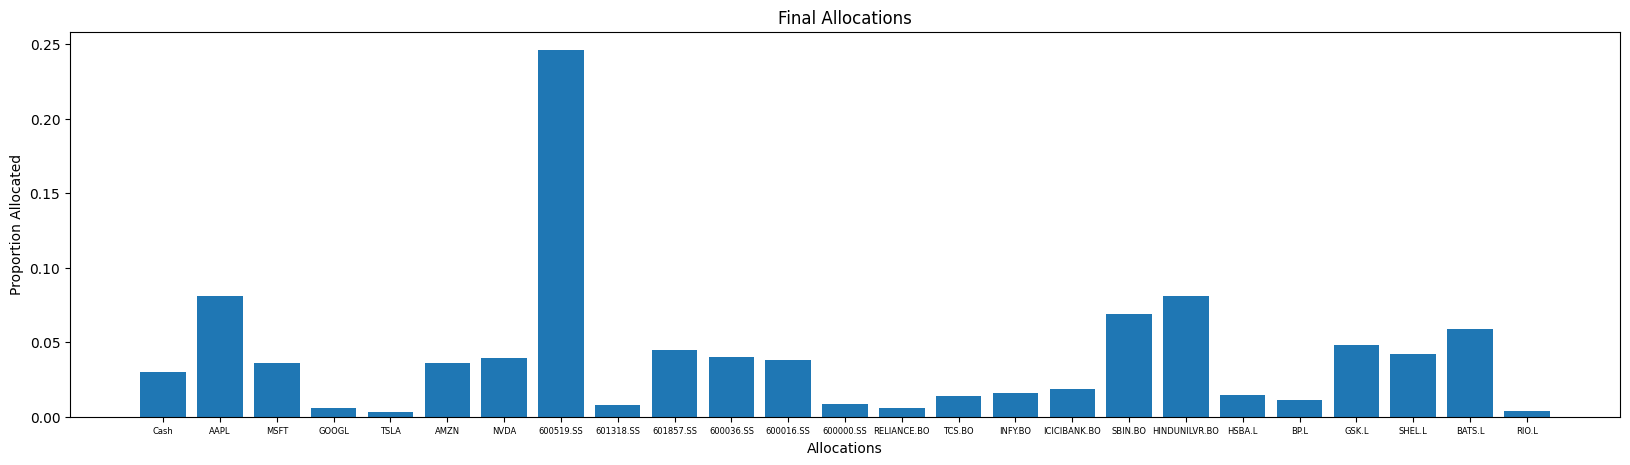

LSTM Output Size: 128 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.34,37.54,18.7394,622.099,0.0559,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,128,44,0


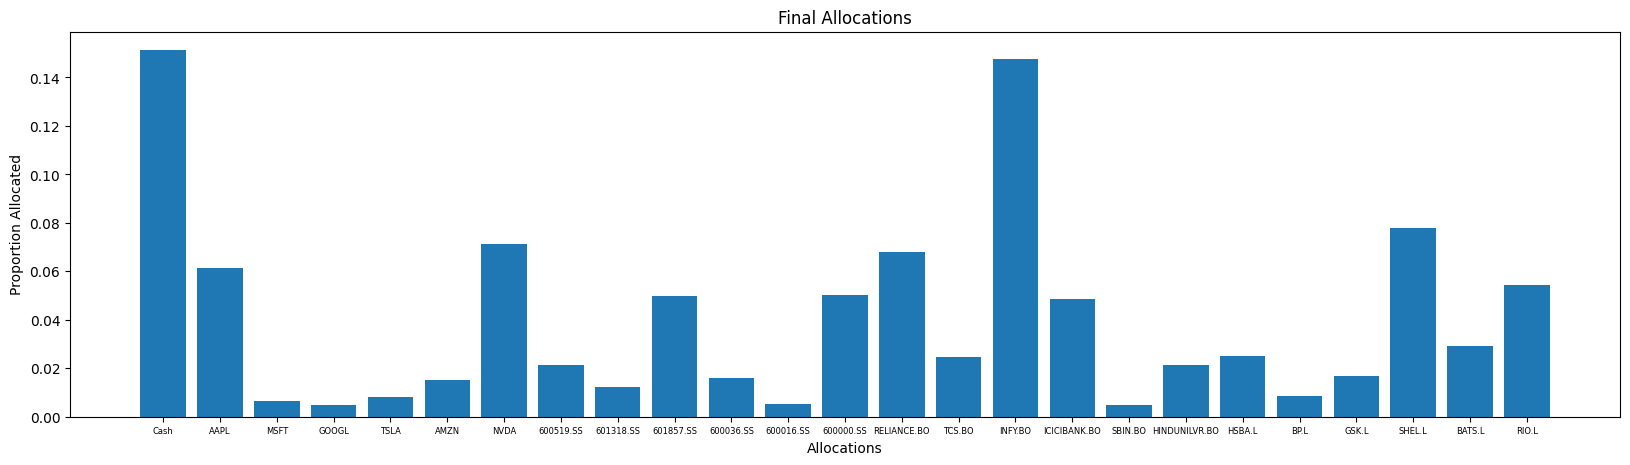

LSTM Output Size: 128 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.95,39.73,45.1999,1001.24,0.0669,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,128,44,0


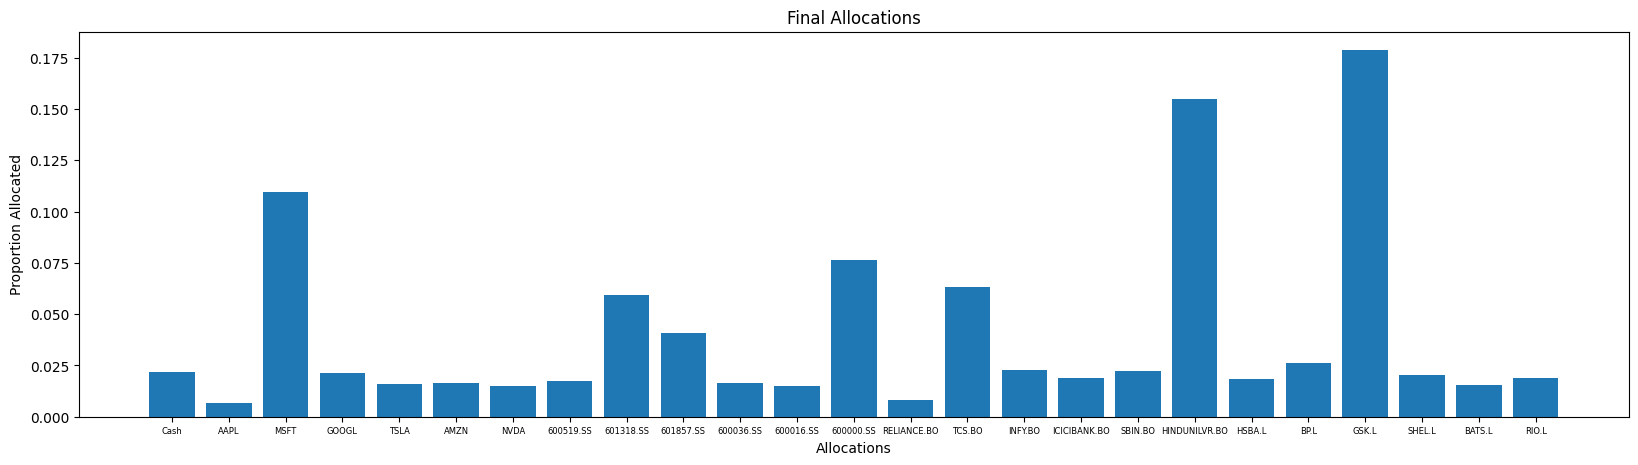

LSTM Output Size: 128 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
9.5,27.34,19.5207,277.093,0.0266,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,128,44,0


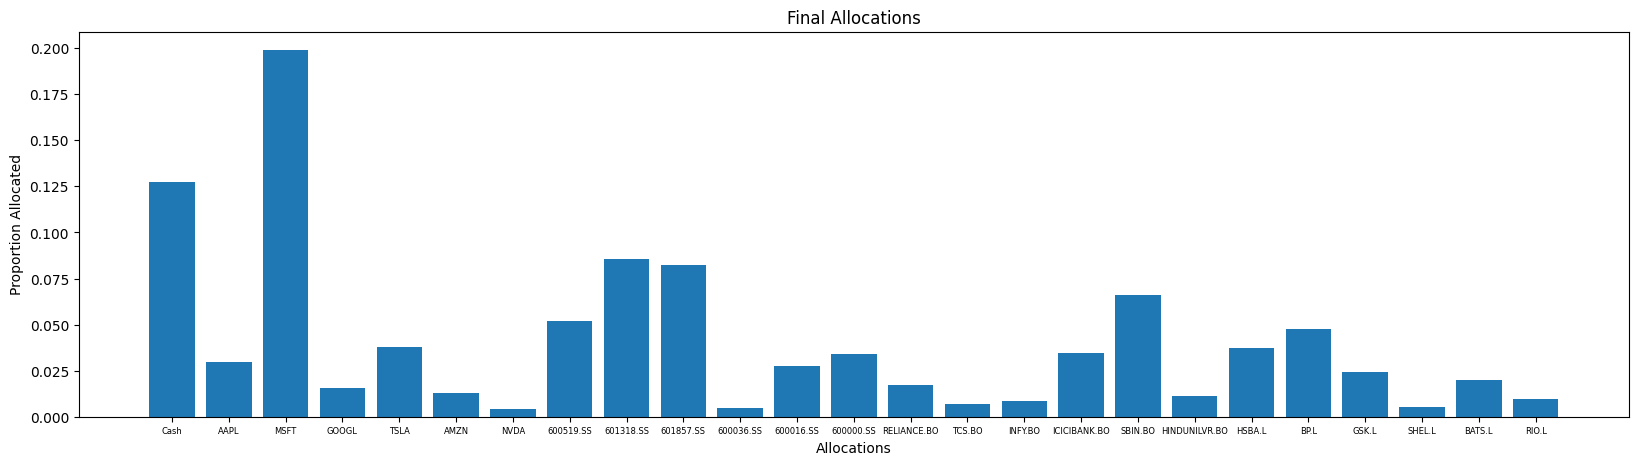

LSTM Output Size: 128 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
7.46,21.14,39.2182,202.193,0.0143,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,128,44,0


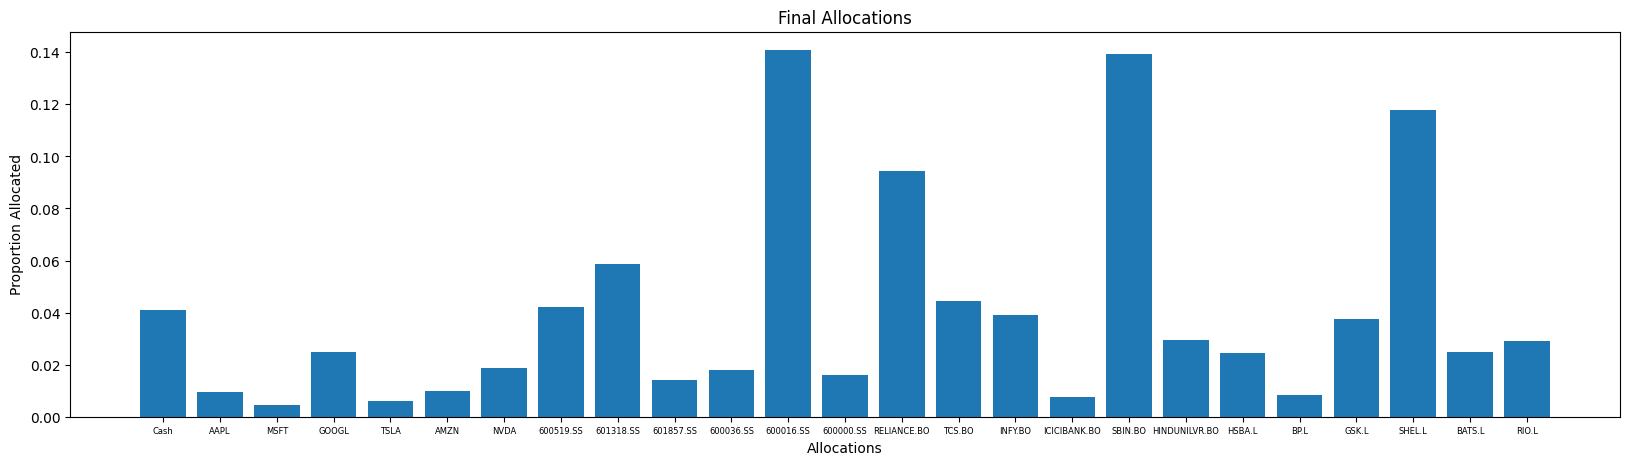

Strategy: SSEBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
72.74,115,32.2281,N/A,0.0543,1111


Strategy: SSEBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
25.39,32.74,41.5565,N/A,0.0448,1111


Strategy: SENSEXBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
54.45,67.07,43.2318,N/A,0.0942,1111


Strategy: SENSEXBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.95,33.15,52.6666,N/A,0.0399,1111


Strategy: FTSEBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-10.91,6.27,36.0202,N/A,-0.0272,1111


Strategy: FTSEBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-21.69,11.37,48.5496,N/A,-0.0377,1111


Strategy: DOWBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
46.76,48,65.8075,N/A,0.0766,1111


Strategy: DOWBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
160.68,160.68,71.3505,N/A,0.1207,1111


Strategy: BuyAndHoldAll | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
40.34,48.28,38.3558,N/A,0.0912,1111


Strategy: BuyAndHoldAll | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
39.21,40.88,48.137,N/A,0.0712,1111


LSTM Output Size: 256 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
40.76,47.43,25.4081,1188.25,0.1062,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,256,44,0


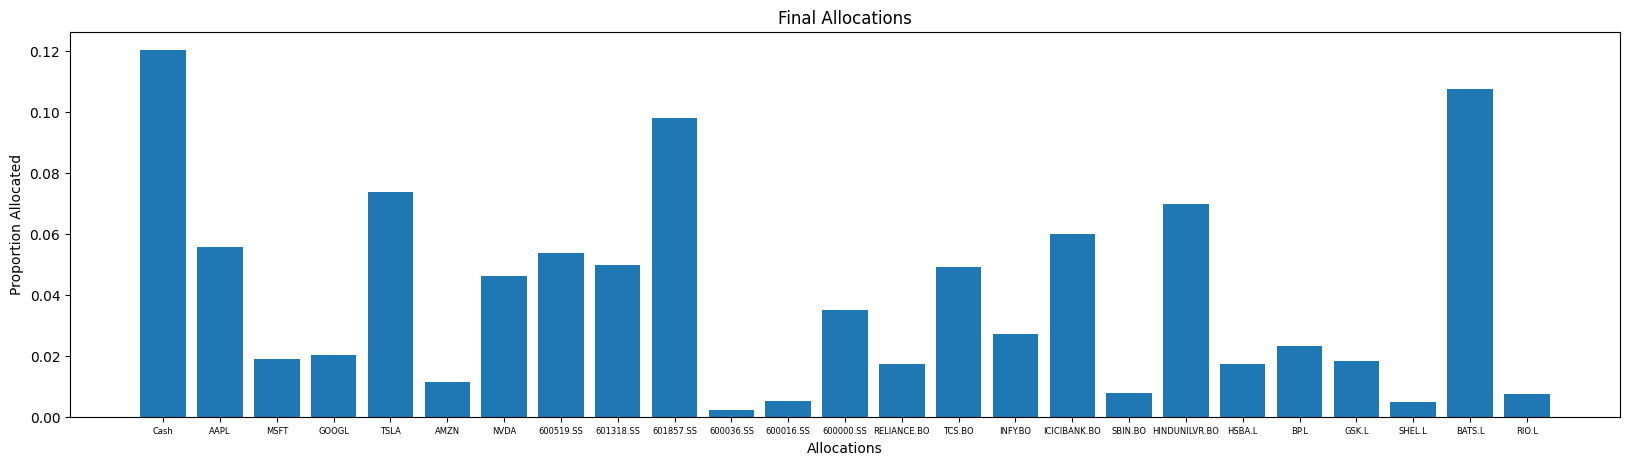

LSTM Output Size: 256 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
46.72,46.72,43.147,1266.15,0.0836,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,256,44,0


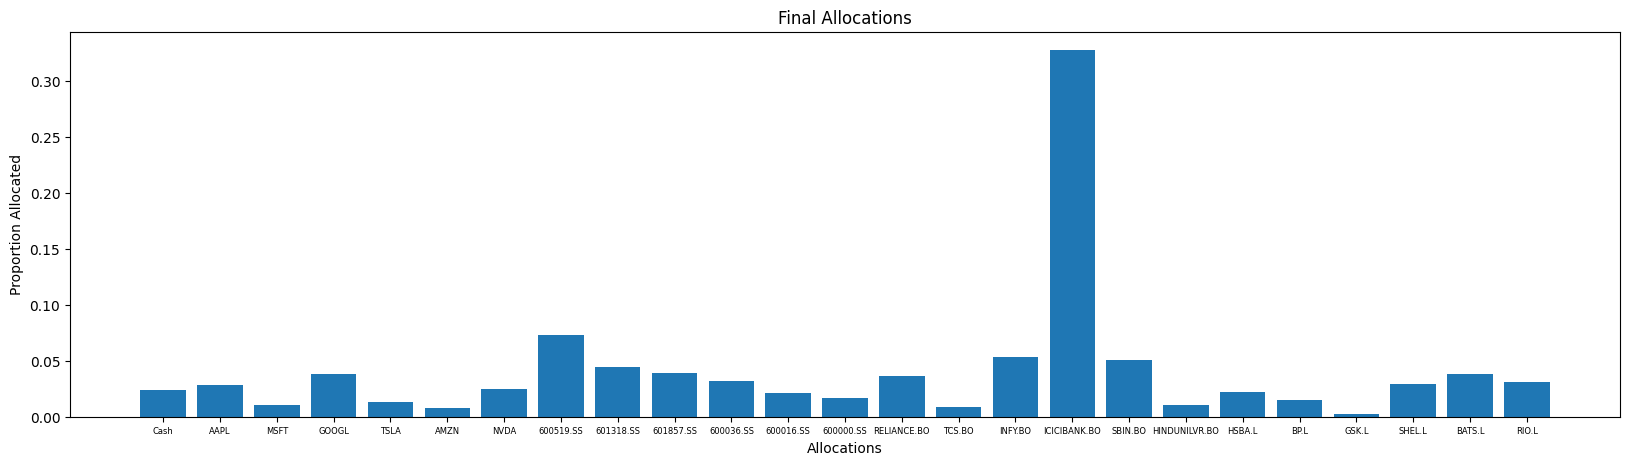

Strategy: RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
29.01,37.71,29.8479,786.286,0.0674,1111


Strategy: RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
25.89,29.58,36.5302,701.541,0.0482,1111


LSTM Output Size: 256 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.9,37.84,20.371,900.786,0.08,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,256,44,0


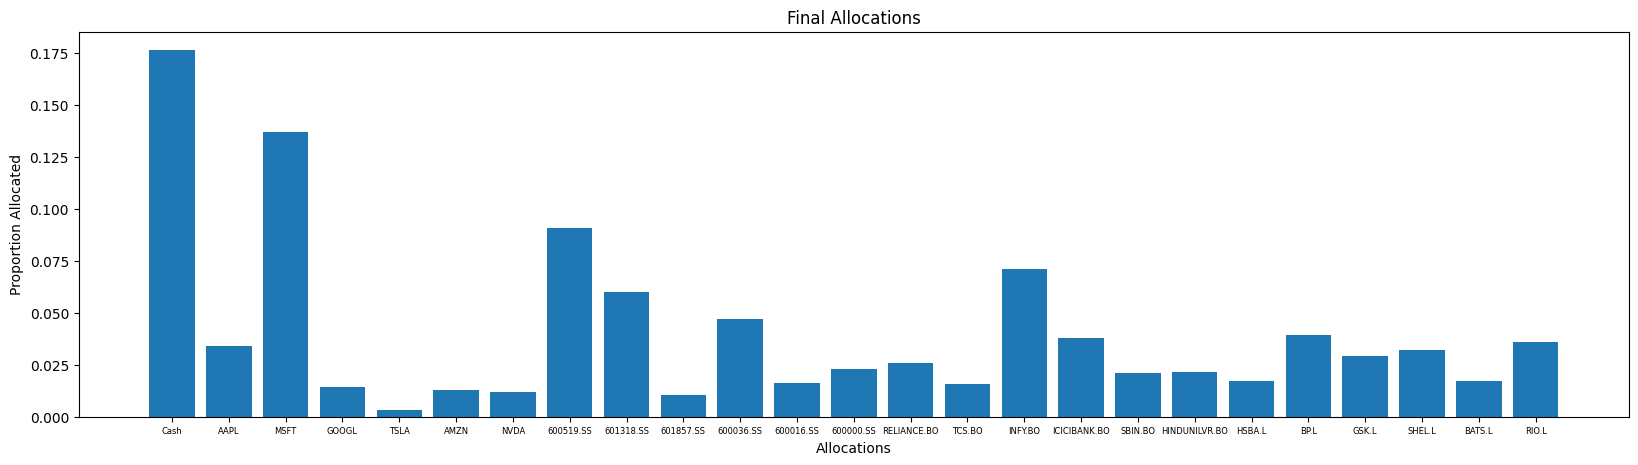

LSTM Output Size: 256 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.45,20.49,43.8458,554.131,0.0392,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,256,44,0


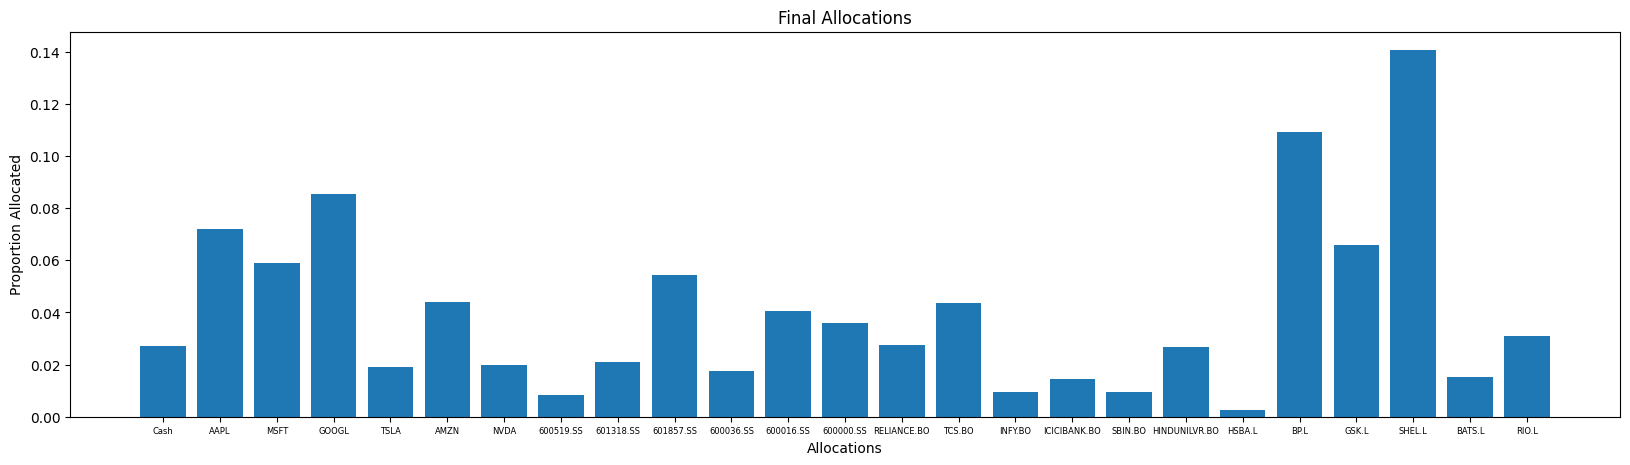

LSTM Output Size: 256 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.45,35.22,16.977,537.987,0.0522,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,256,44,0


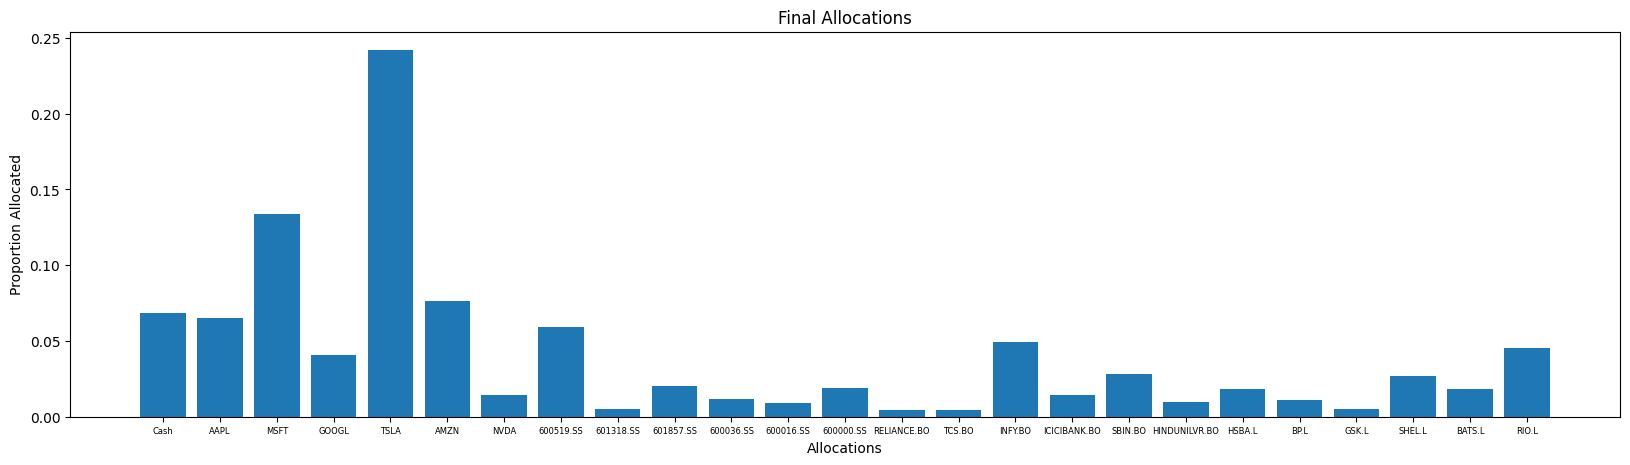

LSTM Output Size: 256 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.41,23.51,41.666,580.102,0.0405,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,256,44,0


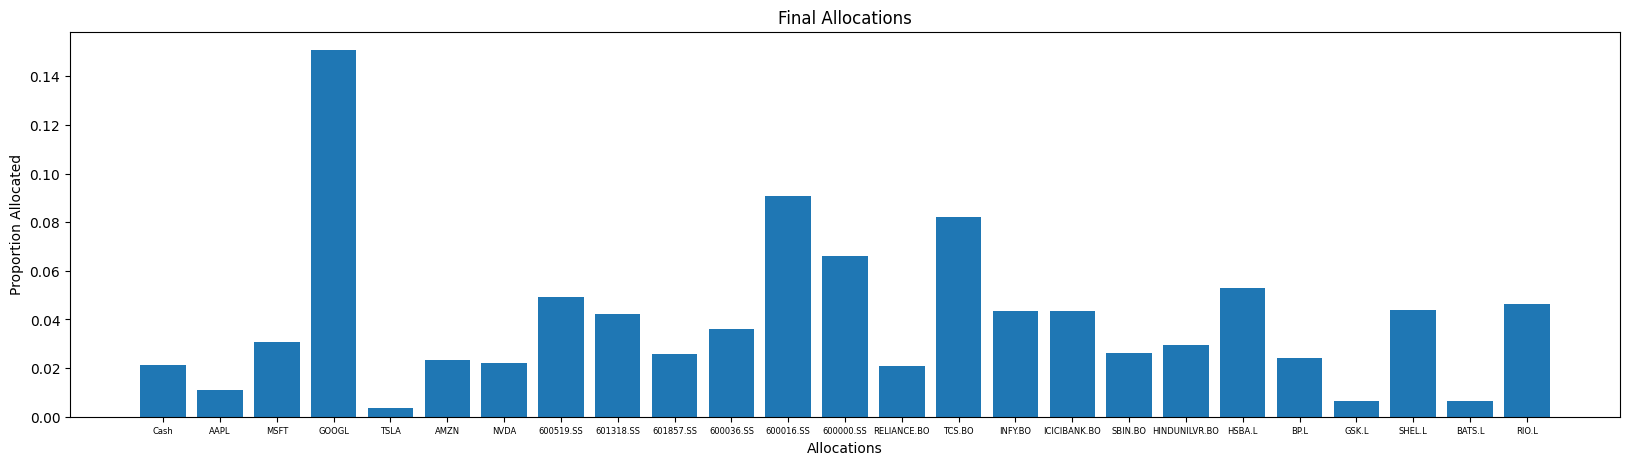

LSTM Output Size: 256 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.44,35.48,24.3761,887.55,0.0874,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,256,44,0


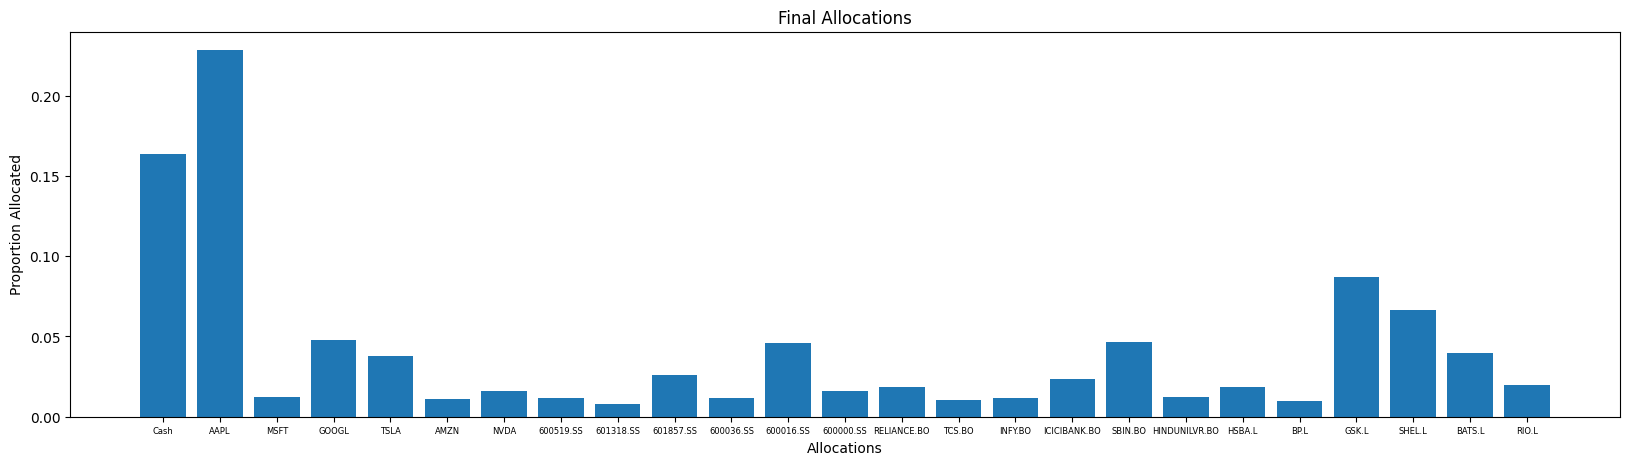

LSTM Output Size: 256 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
14.42,15.46,52.4892,390.718,0.0287,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,256,44,0


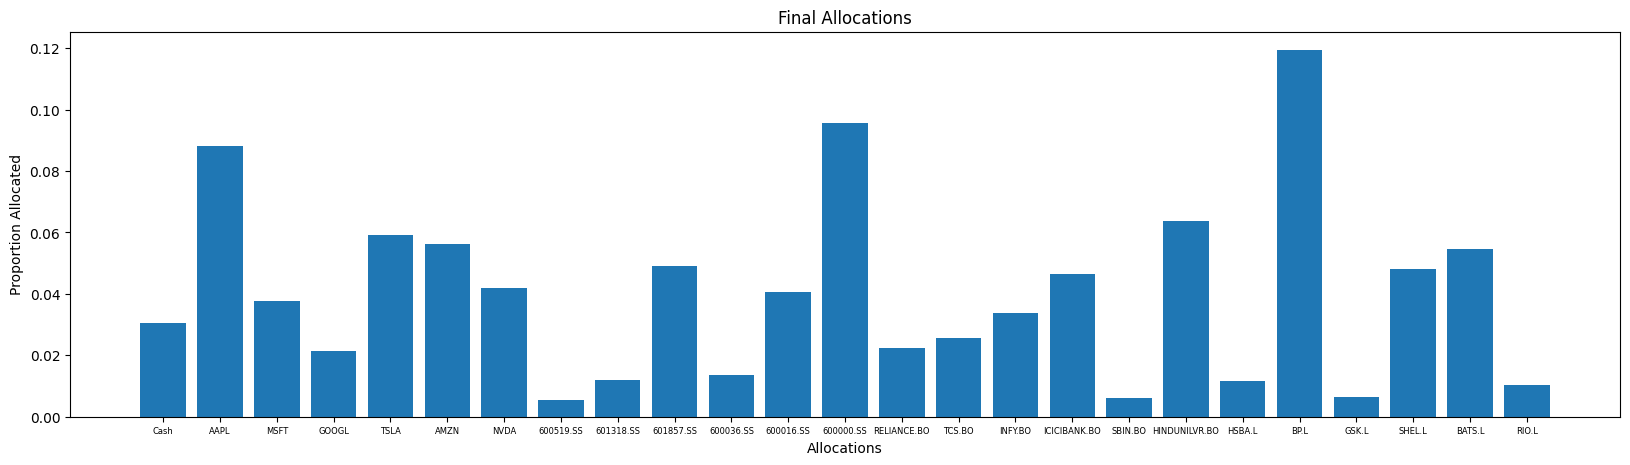

LSTM Output Size: 256 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.55,27.05,21.1031,628.368,0.0603,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,256,44,0


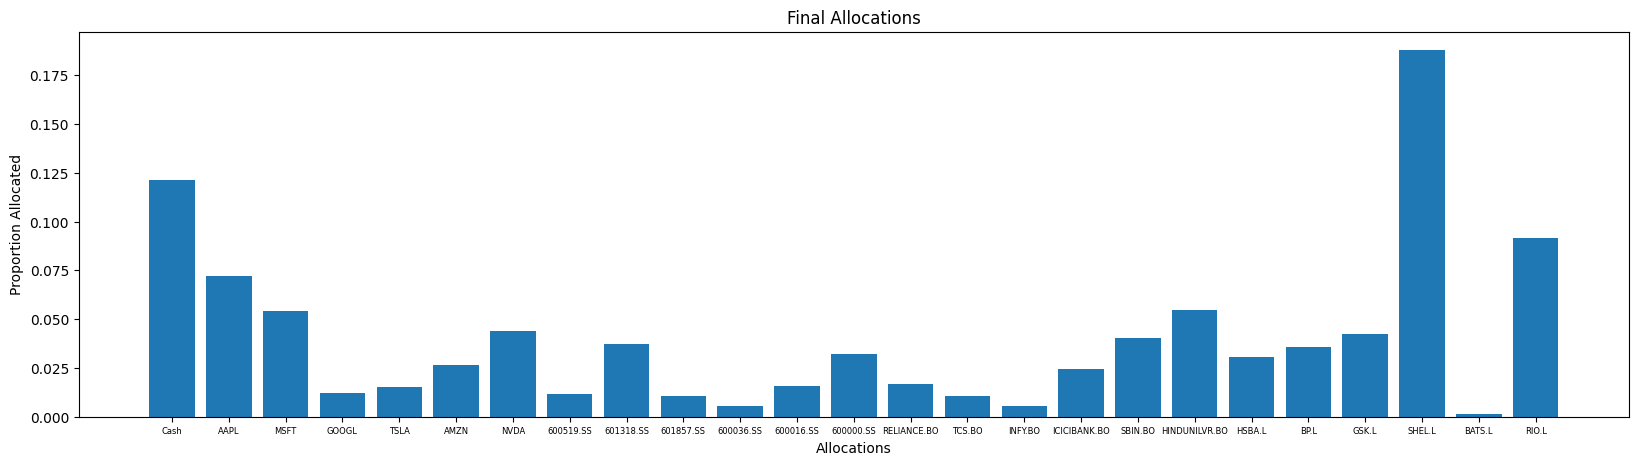

LSTM Output Size: 256 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
45.55,45.78,35.6248,1234.37,0.0784,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,256,44,0


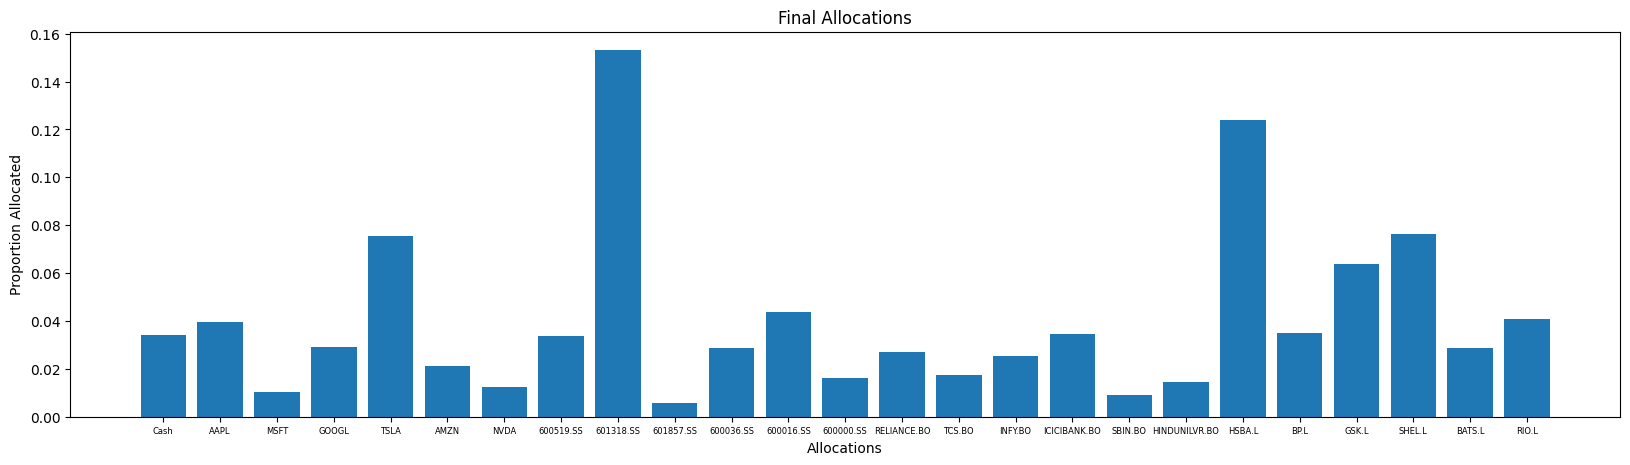

Strategy: SSEBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
72.74,115,32.2281,N/A,0.0543,1111


Strategy: SSEBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
25.39,32.74,41.5565,N/A,0.0448,1111


Strategy: SENSEXBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
54.45,67.07,43.2318,N/A,0.0942,1111


Strategy: SENSEXBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.95,33.15,52.6666,N/A,0.0399,1111


Strategy: FTSEBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-10.91,6.27,36.0202,N/A,-0.0272,1111


Strategy: FTSEBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
-21.69,11.37,48.5496,N/A,-0.0377,1111


Strategy: DOWBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
46.76,48,65.8075,N/A,0.0766,1111


Strategy: DOWBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
160.68,160.68,71.3505,N/A,0.1207,1111


Strategy: BuyAndHoldAll | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
40.34,48.28,38.3558,N/A,0.0912,1111


Strategy: BuyAndHoldAll | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
39.21,40.88,48.137,N/A,0.0712,1111


LSTM Output Size: 512 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.41,30.62,20.358,886.701,0.0825,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,512,44,0


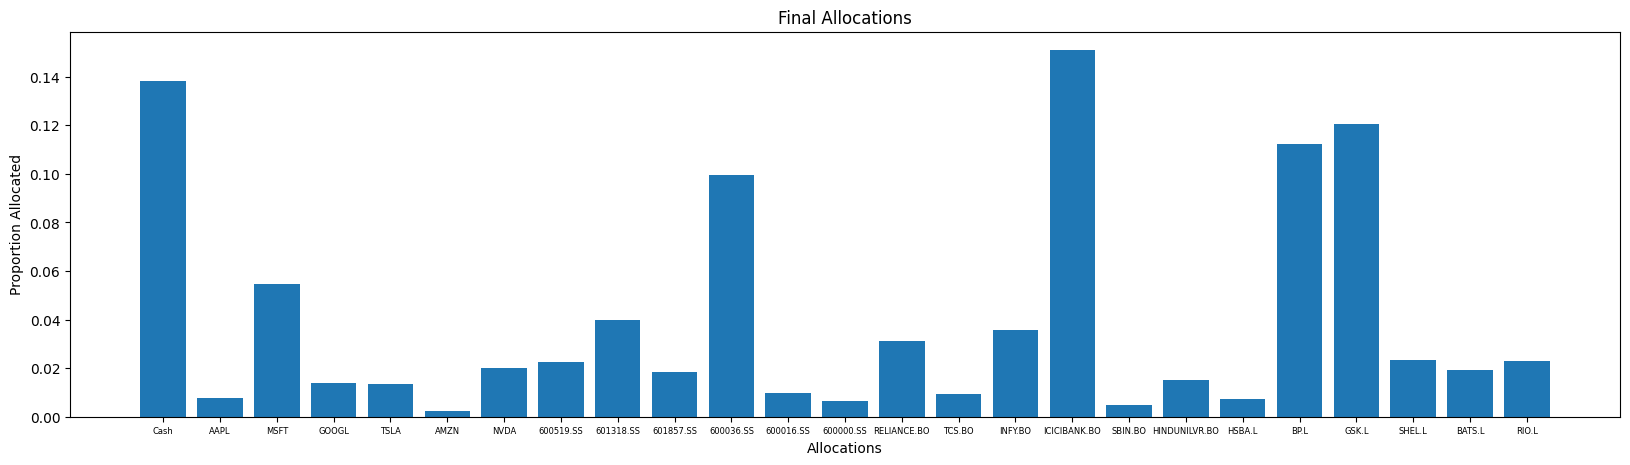

LSTM Output Size: 512 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
61.93,63.02,35.1815,1678.42,0.0967,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,512,44,0


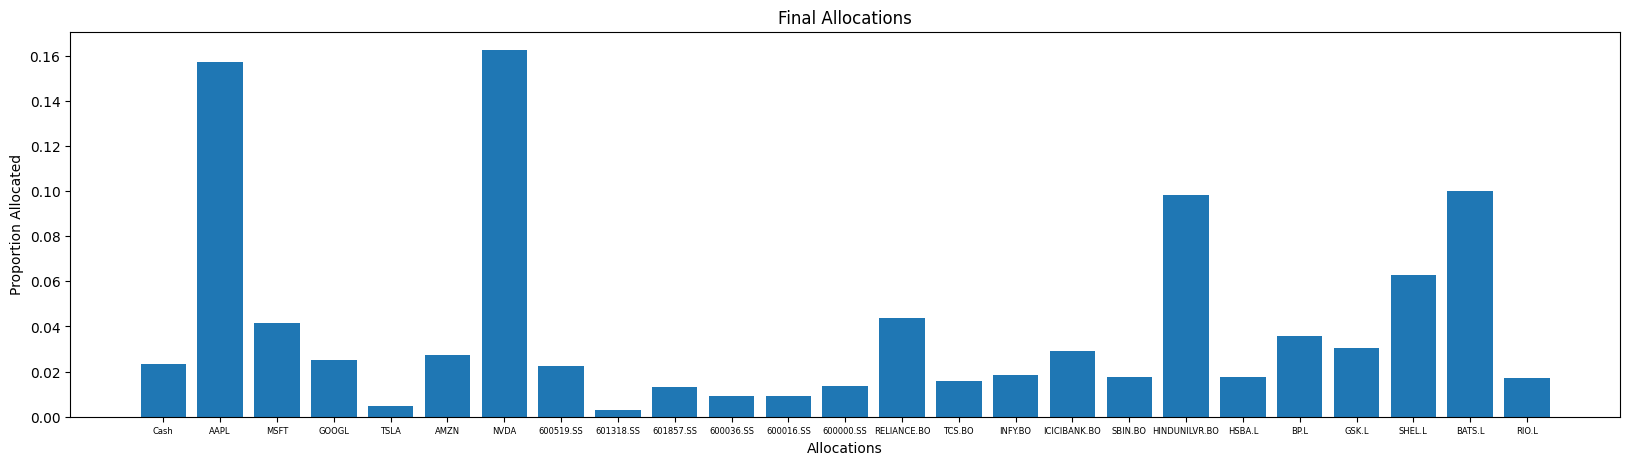

Strategy: RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.63,33.57,25.9428,558.986,0.0481,1111


Strategy: RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
9.94,19.09,40.5102,269.443,0.0192,1111


LSTM Output Size: 512 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.96,31.12,19.0644,523.566,0.046,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,512,44,0


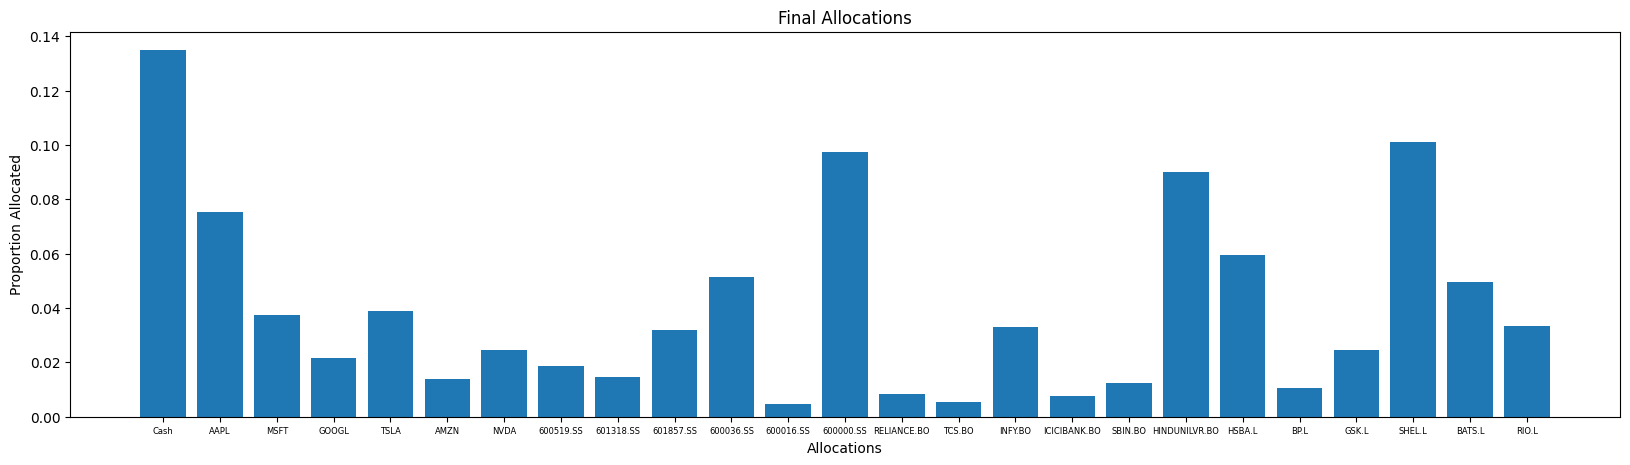

LSTM Output Size: 512 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
42.39,42.39,36.8413,1148.91,0.0728,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,512,44,0


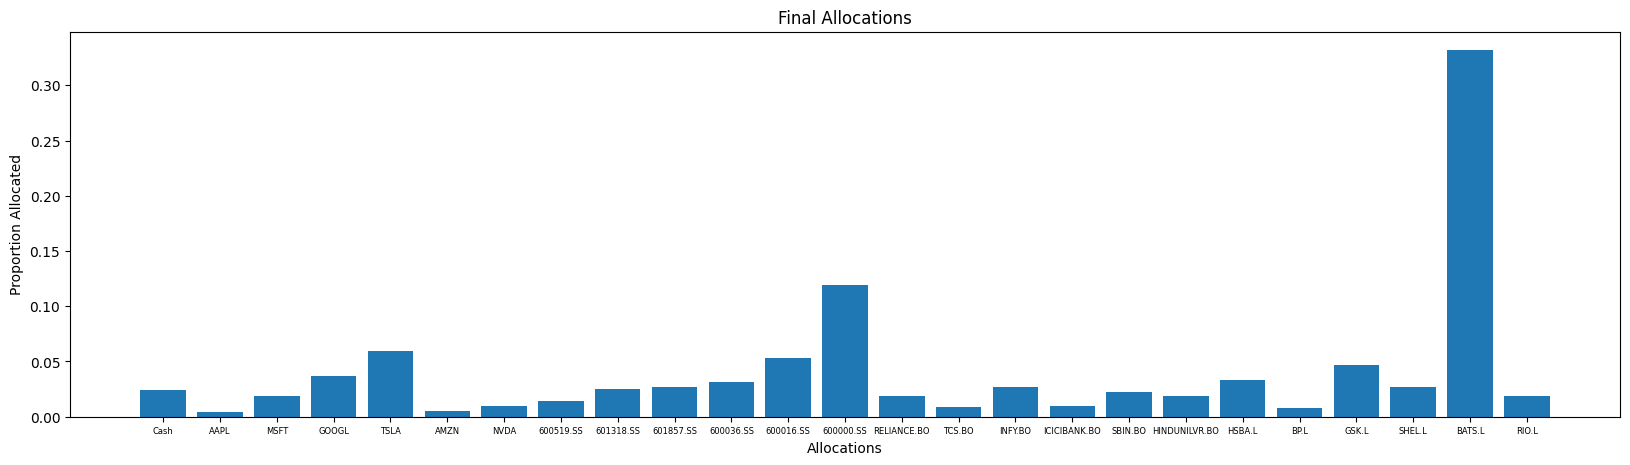

LSTM Output Size: 512 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.12,32.73,19.8394,557.438,0.0543,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,512,44,0


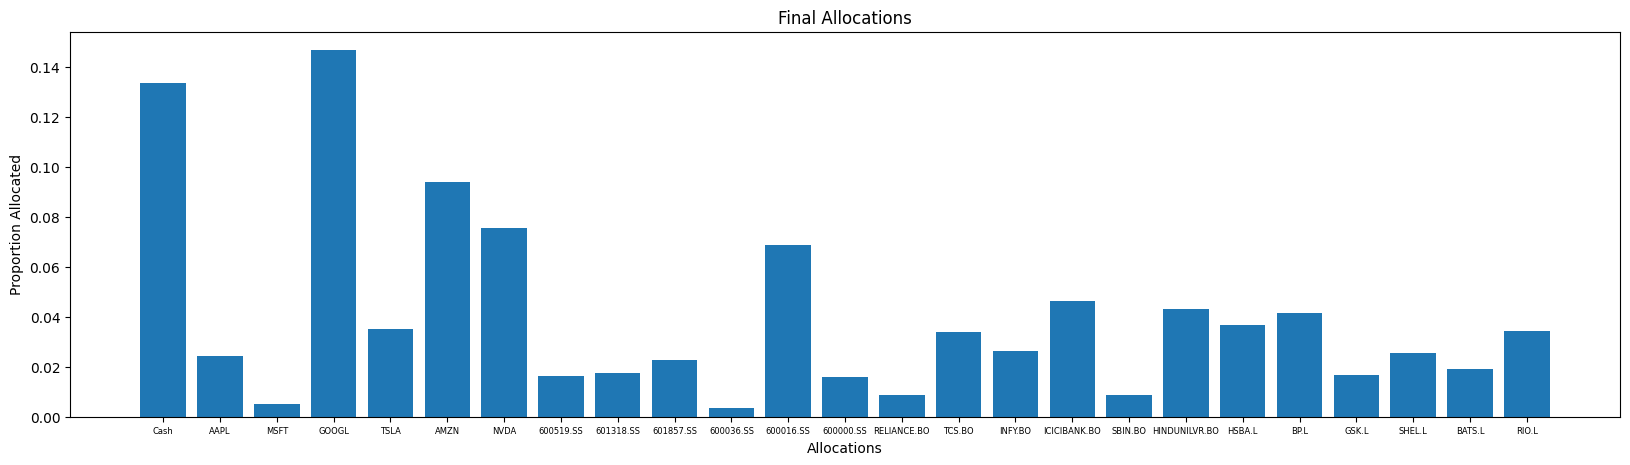

LSTM Output Size: 512 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.33,23.78,39.2405,496.852,0.0336,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,512,44,0


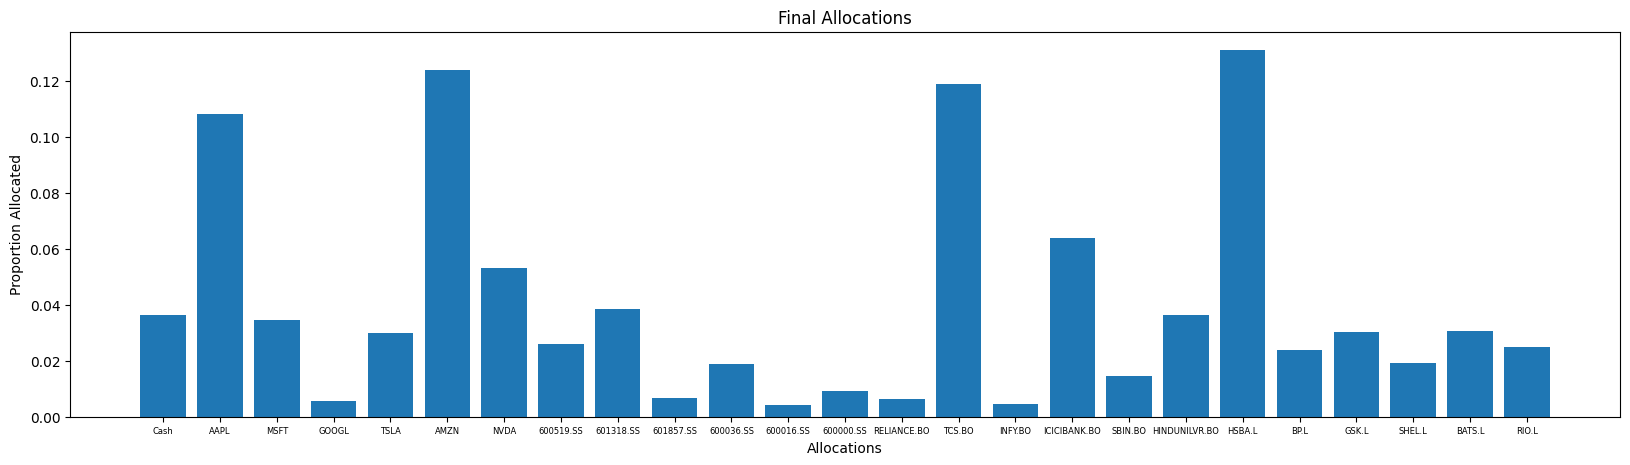

LSTM Output Size: 512 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.67,24.94,19.393,573.351,0.0558,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,512,44,0


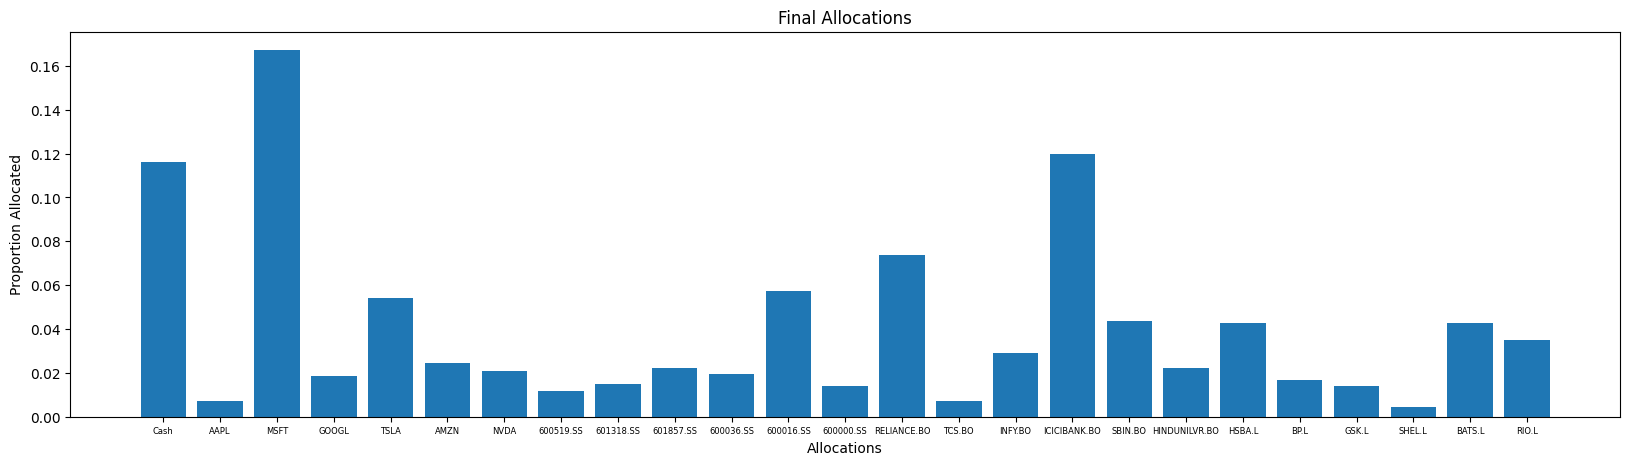

LSTM Output Size: 512 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.84,33.21,44.5567,889.928,0.0586,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,512,44,0


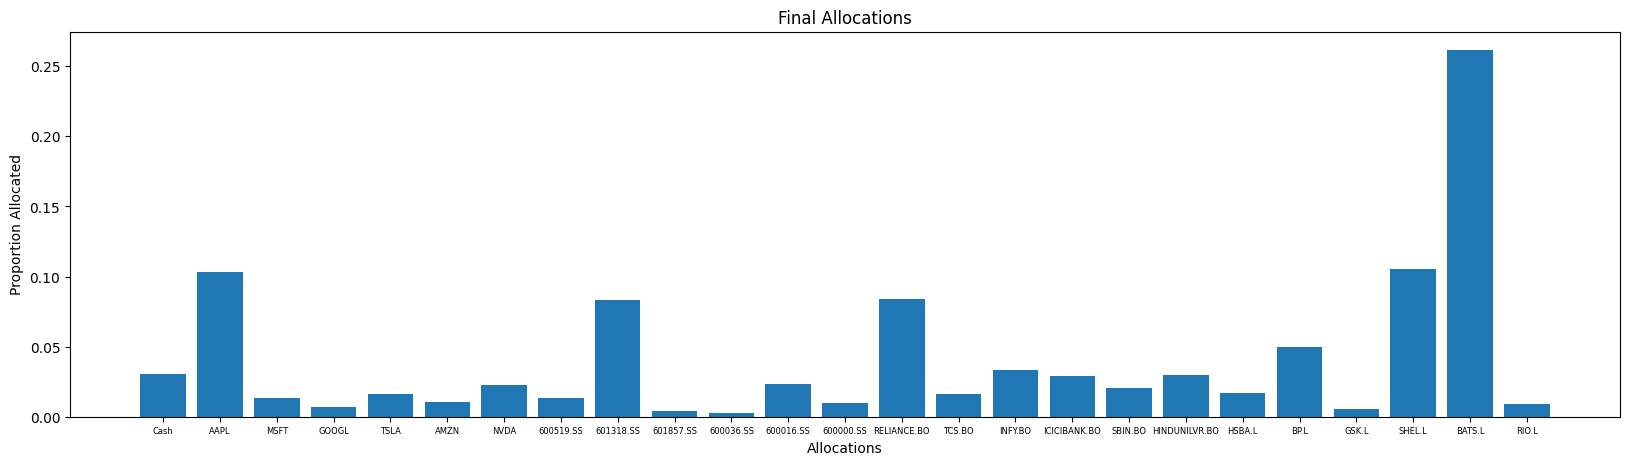

LSTM Output Size: 512 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.47,32.14,32.0545,509.416,0.0486,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,512,44,0


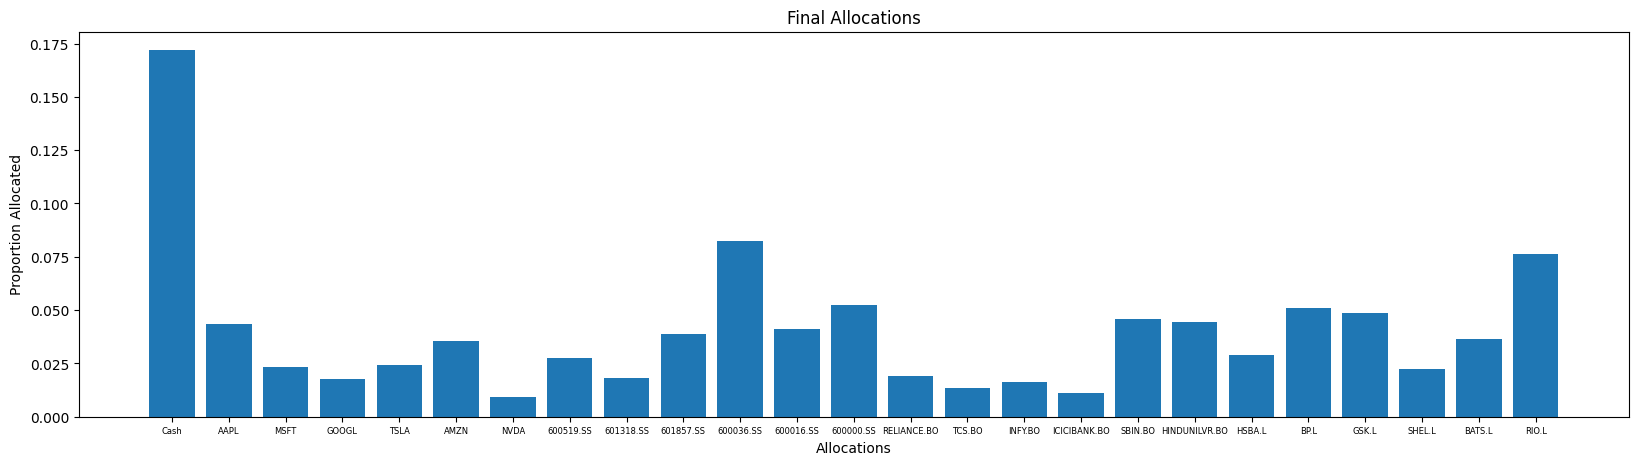

LSTM Output Size: 512 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
39.41,41.16,38.6507,1067.95,0.0754,1111


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
512,512,44,0


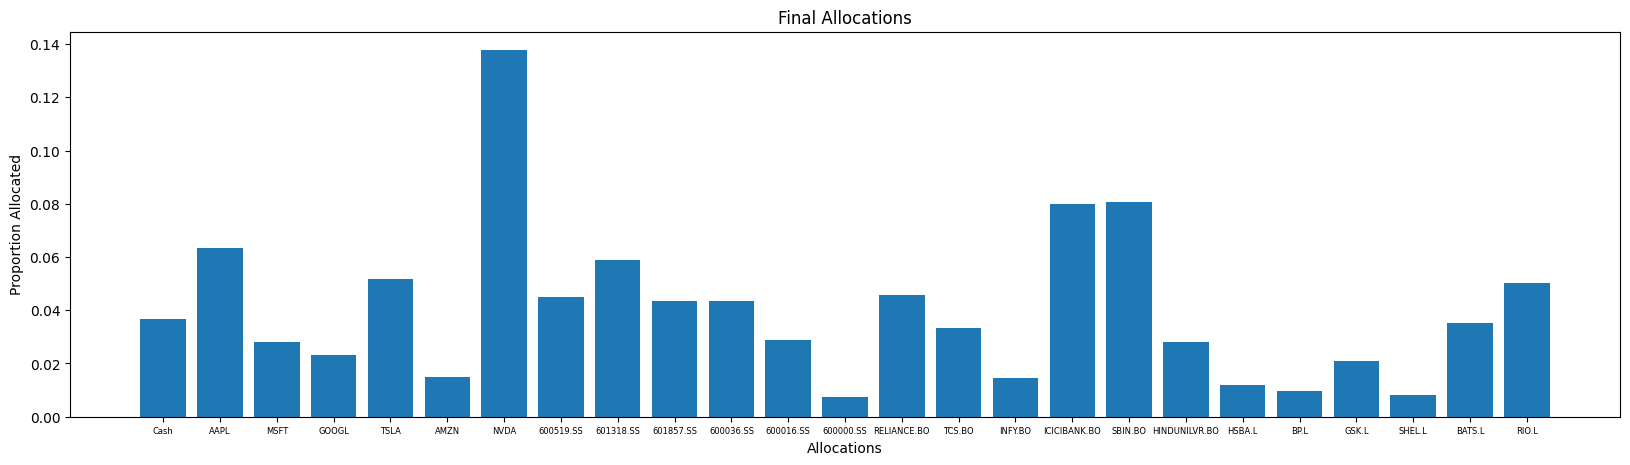

In [58]:
def test():
    if TESTING["RISK_AVERSION"]:
        print("TESTING RISK AVERSION")
        for risk in AGENT_RISK_AVERSIONS:
            trainingLoop(riskAversion=risk)
    elif TESTING["LSTM_OUTPUT_SIZE"]:
        print("TESTING LSTMOUTPUTSIZE")
        for size in LSTMOUTPUTSIZES:
            trainingLoop(lstmOutputSize=size)
    elif TESTING["REWARD_FUNCTION"]:  
        print("TESTING REWARD FUNCTION")
        for r in REWARD_FUNCTIONS:
            trainingLoop(rewardFunction=r)
    elif TESTING["LEARNING_FREQUENCY"]:
        print("TESTING LEARNING FREQUENCY")
        for fr in LEARNING_FREQUENCIES:
            trainingLoop(freq=fr)

for key, value in TESTING.items():
    # TESTING[key] = True
    test()
    # TESTING[key] = False
    break

### Visualise Performance ###

C:\Users\bluem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


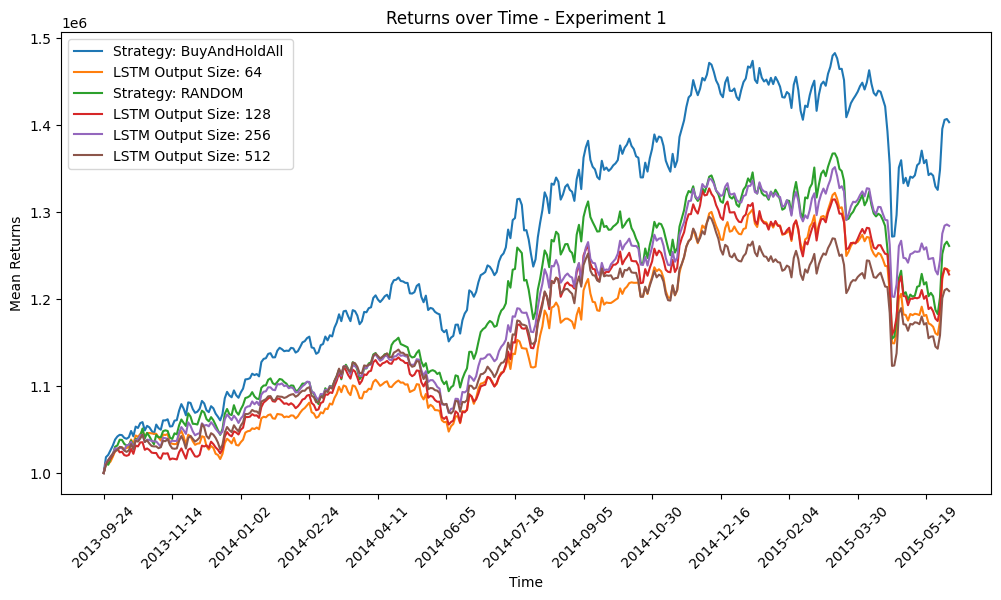

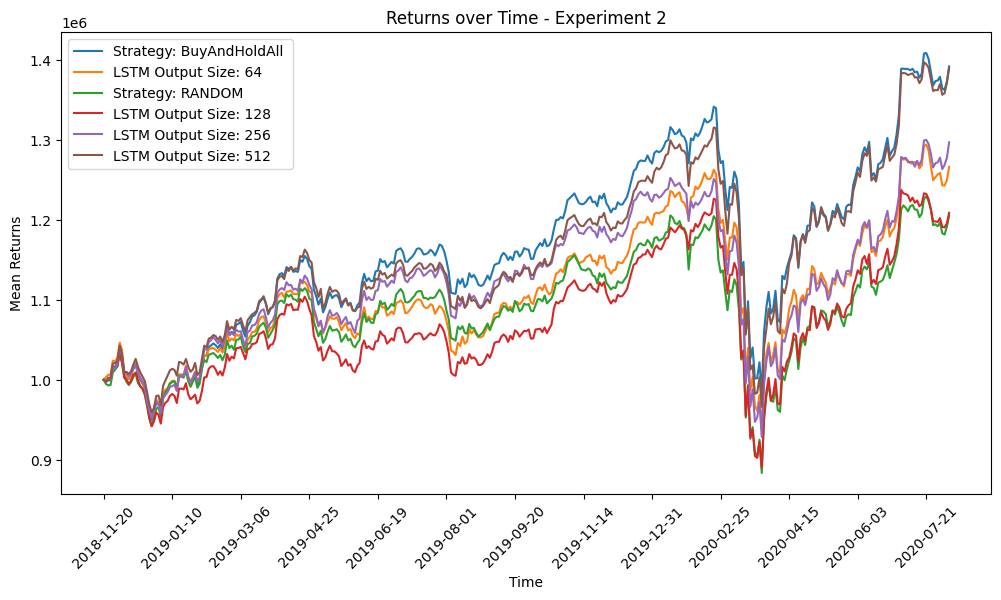

In [59]:
result = np.array_split(times, STARTS, axis=0)[1:]
timeScale = []
for dates in result:
    # print(type(dates[0]))
    # dates = np.datetime_as_string(dates.values, unit='D')
    timeScale.append(dates)

for experiment in range(EXPERIMENTS):
    plt.figure(figsize=(12,6))
    for k, v in averagePerformance.items():
        shouldBeSkipped = False
        for value in list(NON_RL_COMPARISON_STRATEGIES.keys())[:-1]:
            if value in k:
                shouldBeSkipped = True # only need to compare with buy and hold for now
        if shouldBeSkipped:
            continue
        v = np.array(v)
        v = np.mean(v, axis=0)
        if f"Experiment {experiment + 1}" in k:
            array = np.insert(v[int(2/3 * TRAINING_PERIODS) + 2:], 0, START_CASH)
            labels = timeScale[experiment][-len(array):]
            labelIndices = range(0, len(labels), 30)  
            plt.xticks(labelIndices, rotation=45)
            plt.plot(labels, array, label=k.split("|")[0]) ## too tired
    plt.title(f"Returns over Time - Experiment {experiment + 1}")
    plt.xlabel("Time")
    plt.ylabel("Mean Returns")
    plt.legend()
    plt.savefig(f"plots/Results-Experiment_{experiment + 1}_" + datetime.now().strftime("%Y-%m-%d_%H_%M_%S"))
    plt.show()



### Mean, Tabled Results

In [60]:
for k, v in allResults.items():
    table = [list(v[0].keys()) + ["Standard Deviation"]] 
    meanReturns, meanMER, meanPB, meanAPPT, meanSR, timeSteps = 0, 0, 0, 0, 0, 0
    deviations = []
    for resultSet in v:
        meanReturns += resultSet["Cumulative \nReturn (%)"]
        deviations.append(resultSet["Cumulative \nReturn (%)"])
        meanMER += resultSet["Maximum Earning \nRate (%)"]
        meanPB += resultSet["Maximum \nPullback (%)"]
        meanAPPT += (resultSet["Average Profitability \nper Trade"] if type(resultSet["Average Profitability \nper Trade"]) == int else 0)
        meanSR += resultSet["Sharpe Ratio"]
        timeSteps += resultSet["Total Timesteps"]
    array = [meanReturns, meanMER, meanPB, meanAPPT, meanSR, timeSteps, np.std(deviations)]
    array = [i/len(v) for i in array]
    table.append(array)
    tabulate_neatly(table, headers="firstrow", title="MEAN RESULTS FOR: " + k)

MEAN RESULTS FOR: Strategy: SSEBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
72.74,115,32.2281,0,0.0543,1111,0


MEAN RESULTS FOR: Strategy: SSEBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
25.39,32.74,41.5565,0,0.0448,1111,0


MEAN RESULTS FOR: Strategy: SENSEXBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
54.45,67.07,43.2318,0,0.0942,1111,0


MEAN RESULTS FOR: Strategy: SENSEXBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
27.95,33.15,52.6666,0,0.0399,1111,0


MEAN RESULTS FOR: Strategy: FTSEBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
-10.91,6.27,36.0202,0,-0.0272,1111,0


MEAN RESULTS FOR: Strategy: FTSEBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
-21.69,11.37,48.5496,0,-0.0377,1111,0


MEAN RESULTS FOR: Strategy: DOWBuyAndHold | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
46.76,48,65.8075,0,0.0766,1111,0


MEAN RESULTS FOR: Strategy: DOWBuyAndHold | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
160.68,160.68,71.3505,0,0.1207,1111,0


MEAN RESULTS FOR: Strategy: BuyAndHoldAll | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
40.34,48.28,38.3558,0,0.0912,1111,0


MEAN RESULTS FOR: Strategy: BuyAndHoldAll | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
39.21,40.88,48.137,0,0.0712,1111,0


MEAN RESULTS FOR: LSTM Output Size: 64 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
23.256,32.548,24.7128,0,0.06214,1111,1.83704


MEAN RESULTS FOR: LSTM Output Size: 64 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
26.632,31.252,42.717,0,0.04902,1111,1.70394


MEAN RESULTS FOR: Strategy: RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
26.11,37.8825,27.8522,0,0.05865,1111,1.79697


MEAN RESULTS FOR: Strategy: RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
20.5475,24.565,40.7839,0,0.039725,1111,1.55607


MEAN RESULTS FOR: LSTM Output Size: 128 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
22.83,34.318,22.6749,0,0.06074,1111,1.64048


MEAN RESULTS FOR: LSTM Output Size: 128 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
20.888,28.026,37.5736,0,0.03938,1111,2.37336


MEAN RESULTS FOR: LSTM Output Size: 256 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
28.42,36.604,21.6471,0,0.07722,1111,1.57252


MEAN RESULTS FOR: LSTM Output Size: 256 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
29.71,30.392,43.3546,0,0.05408,1111,2.72568


MEAN RESULTS FOR: LSTM Output Size: 512 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
20.926,30.31,22.1419,0,0.05744,1111,0.96136


MEAN RESULTS FOR: LSTM Output Size: 512 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
38.98,40.712,38.8942,0,0.06742,1111,2.83215
